In [1]:
import sys
sys.path.append('../code')
from resnet import *
from funcs import *
from cifar_very_tiny import *
from cifar100_dataset import *    
import torch as t 
import numpy as np
from numpy import polyfit
from numpy import polyval
import tqdm
import matplotlib.pylab as plt
import matplotlib.cm as cm
import json
import hyperparams
from importlib import reload
from scipy.interpolate import interp1d
from PIL import Image
%matplotlib inline
plt.rcParams['figure.figsize']=(12,9)
plt.rcParams['font.size']= 20

ModuleNotFoundError: No module named 'torch.optim.functional'

# Dataset loading

In [2]:
# добавил в загрузку валидационную выборку
# обрати внимание, maxsize --- это размер совокпного обучения и валидации
# поэтому размер обучающей выборки совпадает с тем, что было до этого

#train_loader_no_augumentation, valid_loader, test_loader  = cifar10_loader(batch_size=128, split_train_val=True, use_aug = True)
train_loader_no_augumentation,  test_loader  = cifar10_loader(batch_size=128, split_train_val=False, use_aug = True)


Files already downloaded and verified
Files already downloaded and verified


# Experiments

In [3]:
epoch_num = 100
# epoch_num = 50

run_num = 1 # количество запусков эксперимента

# версия нужна, чтобы различать старые и новые результаты экспериментов. 
# менять нужно каждый раз, когда есть хотя бы незначительные изменения в эксперименте
experiment_version = '1_full_cifar100_'

validate_every_epoch = 5 

# train_splines_every_epoch = 5 # каждые 5 эпох отслеживать траекторию гиперпараметров
train_splines_every_epoch = 2
# train_splines_every_epoch = 3
# train_splines_every_epoch = 10

# размер мини-эпохи в батчах, за которую у нас производится либо обучение спайлов, либо их использование
mini_epoch_size = 10

start_beta = 0.9914
start_temp  = 6.5

### without distillation

In [7]:
# запуск без дистилляции
filename='nodistil'
cifar_base(experiment_version, run_num, epoch_num, start_beta, start_temp, filename, 
           tr_load=train_loader_no_augumentation, t_load=test_loader, 
           validate_every_epoch=validate_every_epoch, class_num=100, lr0=1.0)

current loss:3.718395233154297:   1%|          | 4/391 [00:00<00:11, 34.96it/s] 

{'epoch': 0, 'test loss': 6.020641803741455, 'accuracy': 0.010300000198185444}


current loss:3.2354321479797363:   1%|          | 3/391 [00:00<00:15, 25.39it/s]

{'epoch': 4, 'test loss': 5.7960357666015625, 'accuracy': 0.012299999594688416}


current loss:3.22550892829895:   1%|          | 4/391 [00:00<00:10, 35.59it/s]  

{'epoch': 9, 'test loss': 6.373513221740723, 'accuracy': 0.010099999606609344}


current loss:3.0639986991882324:  52%|█████▏    | 204/391 [00:06<00:05, 33.92it/s]


KeyboardInterrupt: 

In [9]:
keys = t.load('/home/legin/reps/RepDistiller/save/models/ResNet50_vanilla/ckpt_epoch_240.pth', map_location=device)
keys['model']

OrderedDict([('conv1.weight',
              tensor([[[[ 3.1516e-09, -4.0957e-09, -4.8978e-10],
                        [-8.9434e-09, -2.6926e-08, -1.6615e-08],
                        [-3.3874e-09, -1.6361e-08, -9.1759e-09]],
              
                       [[ 8.0482e-09, -2.1718e-09,  6.4634e-09],
                        [-4.0161e-09, -2.5702e-08, -5.4472e-09],
                        [ 2.6831e-09, -8.7029e-09,  2.9037e-09]],
              
                       [[ 1.0930e-08,  2.4734e-09,  9.5142e-09],
                        [ 2.5757e-09, -1.3311e-08,  3.7995e-09],
                        [ 5.3763e-09, -1.5486e-09,  1.0450e-08]]],
              
              
                      [[[ 9.9989e-02, -3.2645e-02,  8.5708e-02],
                        [ 2.1988e-02, -1.8818e-01,  7.7817e-03],
                        [ 9.8047e-02, -1.6410e-02,  1.2394e-01]],
              
                       [[ 5.7238e-02, -5.8037e-02,  2.0395e-02],
                        [-1.2506e-02, -1.7192

In [10]:
teacher = ResNet50(num_classes=100)
teacher.load_state_dict(t.load('/home/legin/reps/RepDistiller/save/models/ResNet50_vanilla/ckpt_epoch_240.pth', map_location=device)['model'] )
_ = teacher.eval()
teacher = teacher.cuda()

### with distillation and start_lambda1, start_temp

In [11]:
# Запуск --- с CNN-дистилляцией
filename='distil'
cifar_base(experiment_version, run_num, epoch_num, start_beta, start_temp, filename, 
           tr_load=train_loader_no_augumentation, t_load=test_loader, 
           validate_every_epoch=validate_every_epoch, mode='distil', lr0=1.0, class_num=100, logits=teacher)

  0%|          | 0/391 [00:00<?, ?it/s]../code/funcs.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = F.log_softmax(batch_logits/temp)
  0%|          | 0/391 [00:00<?, ?it/s]

{'epoch': 0, 'test loss': 77.6673355102539, 'accuracy': 0.09999999403953552}


current loss:0.768500804901123:  19%|█▉        | 74/391 [00:22<01:37,  3.26it/s] 


KeyboardInterrupt: 

### with random metaparameter values

In [6]:
# Запуск --- со случаными значениями гиперпараметров
filename='random'
cifar_base(experiment_version, run_num, epoch_num, start_beta, start_temp, filename, 
           tr_load=train_loader_no_augumentation, t_load=test_loader, 
           validate_every_epoch=validate_every_epoch, mode='random', logits=teacher, lr0=1e-2)

  0%|          | 0/391 [00:00<?, ?it/s]../code/funcs.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = F.log_softmax(batch_logits/temp)
current loss:2.325329303741455:   0%|          | 1/391 [00:00<00:42,  9.18it/s]

{'epoch': 0, 'test loss': 1.8006958961486816, 'accuracy': 0.33869999647140503, 'temp': 7.346740245819092, 'lambda1': 0.3745401203632355, 'lambda2': 0.9507142901420593}


current loss:1.9029803276062012:   0%|          | 1/391 [00:00<00:42,  9.25it/s]

{'epoch': 4, 'test loss': 1.3778523206710815, 'accuracy': 0.49799999594688416, 'temp': 7.346740245819092, 'lambda1': 0.3745401203632355, 'lambda2': 0.9507142901420593}


current loss:1.6795982122421265:   0%|          | 1/391 [00:00<00:41,  9.36it/s]

{'epoch': 9, 'test loss': 1.2216373682022095, 'accuracy': 0.5712000131607056, 'temp': 7.346740245819092, 'lambda1': 0.3745401203632355, 'lambda2': 0.9507142901420593}


current loss:1.6786752939224243:   0%|          | 1/391 [00:00<00:41,  9.38it/s]

{'epoch': 14, 'test loss': 1.138881802558899, 'accuracy': 0.5974000096321106, 'temp': 7.346740245819092, 'lambda1': 0.3745401203632355, 'lambda2': 0.9507142901420593}


current loss:1.557547688484192:   0%|          | 1/391 [00:00<00:41,  9.44it/s]

{'epoch': 19, 'test loss': 1.0714799165725708, 'accuracy': 0.6256999969482422, 'temp': 7.346740245819092, 'lambda1': 0.3745401203632355, 'lambda2': 0.9507142901420593}


current loss:1.531583309173584:   0%|          | 1/391 [00:00<00:42,  9.25it/s]

{'epoch': 24, 'test loss': 1.049824833869934, 'accuracy': 0.630299985408783, 'temp': 7.346740245819092, 'lambda1': 0.3745401203632355, 'lambda2': 0.9507142901420593}


current loss:1.521019697189331:   0%|          | 1/391 [00:00<00:41,  9.43it/s]

{'epoch': 29, 'test loss': 1.008122205734253, 'accuracy': 0.6485999822616577, 'temp': 7.346740245819092, 'lambda1': 0.3745401203632355, 'lambda2': 0.9507142901420593}


current loss:1.4009883403778076:   0%|          | 1/391 [00:00<00:41,  9.46it/s]

{'epoch': 34, 'test loss': 1.0033351182937622, 'accuracy': 0.6510999798774719, 'temp': 7.346740245819092, 'lambda1': 0.3745401203632355, 'lambda2': 0.9507142901420593}


current loss:1.4135613441467285:   0%|          | 1/391 [00:00<00:42,  9.15it/s]

{'epoch': 39, 'test loss': 0.9847080111503601, 'accuracy': 0.6584999561309814, 'temp': 7.346740245819092, 'lambda1': 0.3745401203632355, 'lambda2': 0.9507142901420593}


current loss:1.3071675300598145:   0%|          | 1/391 [00:00<00:40,  9.52it/s]

{'epoch': 44, 'test loss': 0.9530309438705444, 'accuracy': 0.670699954032898, 'temp': 7.346740245819092, 'lambda1': 0.3745401203632355, 'lambda2': 0.9507142901420593}


current loss:1.4513254165649414:   0%|          | 1/391 [00:00<00:41,  9.50it/s]

{'epoch': 49, 'test loss': 0.9698139429092407, 'accuracy': 0.6711999773979187, 'temp': 7.346740245819092, 'lambda1': 0.3745401203632355, 'lambda2': 0.9507142901420593}


current loss:1.4359780550003052:   0%|          | 1/391 [00:00<00:42,  9.08it/s]

{'epoch': 54, 'test loss': 0.9453057646751404, 'accuracy': 0.675000011920929, 'temp': 7.346740245819092, 'lambda1': 0.3745401203632355, 'lambda2': 0.9507142901420593}


current loss:1.3419435024261475:   9%|▉         | 35/391 [00:03<00:37,  9.57it/s]


KeyboardInterrupt: 

### with distillation and 2 coefficients

In [16]:
for x,y in train_loader_no_augumentation:
    1/0

ZeroDivisionError: division by zero

In [8]:

next(iter(valid_loader_iter))

StopIteration: 

In [16]:
cnt/total

0.9994666666666666

In [21]:
total = 0
cnt = 0
logits = np.load('../code/logits_cnn.npy')
for batch_id, (_,y) in enumerate(train_loader_no_augumentation):
    y2 = logits[batch_id*128:(batch_id+1)*128]
    y2 = y2[:y.shape[0]].argmax(1)
    y = y.cpu().numpy()
    total+=y.shape[0]
    cnt += np.equal(y, y2).sum()
    

In [5]:
for x,y in tqdm.tqdm(train_loader_no_augumentation):
    teacher(x.cuda())

 15%|█▍        | 52/352 [00:03<00:22, 13.41it/s]


KeyboardInterrupt: 

In [8]:
train_loader_no_augumentation, valid_loader, test_loader  = cifar10_loader(batch_size=128, split_train_val=True, use_aug = True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Запуск --- с CNN-дистилляцией и оптимизацией гиперпараметров, 2-lambda
validate_every_epoch = 1
filename='opt'
cifar_with_validation_set(experiment_version, run_num, epoch_num, filename,
                          tr_s_epoch=train_splines_every_epoch,
                          m_e=mini_epoch_size,
                          tr_load=train_loader_no_augumentation, 
                          t_load=test_loader, 
                          val_load=valid_loader, 
                          validate_every_epoch=validate_every_epoch, 
                          mode='opt', lr0=1.0, lr=1e-4, logits=teacher)

current loss:2.7471096515655518:   0%|          | 1/352 [00:00<00:52,  6.73it/s]

[Parameter containing:
tensor(0.3745, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9507, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.3467, device='cuda:0', requires_grad=True)]


current loss:2.017169237136841: 100%|██████████| 352/352 [00:47<00:00,  7.46it/s] 
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
current loss:1.9512712955474854:   0%|          | 1/352 [00:00<00:50,  7.00it/s]

{'epoch': 0, 'test loss': 1.4646663665771484, 'val loss': 1.5310757160186768, 'accuracy': 0.4607999920845032, 'temp': 9.993600517511368, 'lambda1': 0.5942785739898682, 'lambda2': 0.7210388779640198}
[Parameter containing:
tensor(0.3817, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9496, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.3435, device='cuda:0', requires_grad=True)]


current loss:1.9603588581085205:   0%|          | 1/352 [00:00<00:51,  6.88it/s]

{'epoch': 1, 'test loss': 1.6251238584518433, 'val loss': 1.7366634607315063, 'accuracy': 0.45729997754096985, 'temp': 9.99354150891304, 'lambda1': 0.5963164567947388, 'lambda2': 0.7211570143699646}
[Parameter containing:
tensor(0.3901, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9502, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.3343, device='cuda:0', requires_grad=True)]


current loss:1.7447643280029297:   0%|          | 1/352 [00:00<00:49,  7.04it/s]

{'epoch': 2, 'test loss': 1.35105562210083, 'val loss': 1.4168297052383423, 'accuracy': 0.526199996471405, 'temp': 9.993515545129776, 'lambda1': 0.5975661277770996, 'lambda2': 0.7202600240707397}
[Parameter containing:
tensor(0.3953, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9458, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.3303, device='cuda:0', requires_grad=True)]


current loss:1.618308663368225:   0%|          | 1/352 [00:00<00:50,  6.94it/s]

{'epoch': 3, 'test loss': 1.2592028379440308, 'val loss': 1.3504139184951782, 'accuracy': 0.5598999857902527, 'temp': 9.993478959798813, 'lambda1': 0.5984155535697937, 'lambda2': 0.7202606797218323}
[Parameter containing:
tensor(0.3989, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9458, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.3246, device='cuda:0', requires_grad=True)]


current loss:1.621582269668579:   0%|          | 1/352 [00:00<00:51,  6.81it/s]

{'epoch': 4, 'test loss': 1.2652106285095215, 'val loss': 1.3378385305404663, 'accuracy': 0.5572999715805054, 'temp': 9.993486040830613, 'lambda1': 0.5983740091323853, 'lambda2': 0.7205675840377808}
[Parameter containing:
tensor(0.3987, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9473, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.3257, device='cuda:0', requires_grad=True)]


current loss:1.7012732028961182:   0%|          | 1/352 [00:00<00:51,  6.88it/s]

{'epoch': 5, 'test loss': 1.23069167137146, 'val loss': 1.316227912902832, 'accuracy': 0.5629000067710876, 'temp': 9.99349312186241, 'lambda1': 0.5983330607414246, 'lambda2': 0.7201896905899048}
[Parameter containing:
tensor(0.3985, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9454, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.3269, device='cuda:0', requires_grad=True)]


current loss:1.6567314863204956:   0%|          | 1/352 [00:00<00:50,  6.99it/s]

{'epoch': 6, 'test loss': 1.1931941509246826, 'val loss': 1.274141550064087, 'accuracy': 0.5862999558448792, 'temp': 9.993495482206345, 'lambda1': 0.5985835194587708, 'lambda2': 0.7201385498046875}
[Parameter containing:
tensor(0.3996, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9451, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.3271, device='cuda:0', requires_grad=True)]


current loss:1.4835504293441772:   0%|          | 1/352 [00:00<00:50,  7.02it/s]

{'epoch': 7, 'test loss': 1.2655812501907349, 'val loss': 1.3567137718200684, 'accuracy': 0.5917999744415283, 'temp': 9.993516725301742, 'lambda1': 0.5981133580207825, 'lambda2': 0.7197768688201904}
[Parameter containing:
tensor(0.3976, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9434, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.3304, device='cuda:0', requires_grad=True)]


current loss:1.5739327669143677:   0%|          | 1/352 [00:00<00:50,  6.99it/s]

{'epoch': 8, 'test loss': 1.1918245553970337, 'val loss': 1.245684027671814, 'accuracy': 0.5913000106811523, 'temp': 9.993567472696304, 'lambda1': 0.5967147946357727, 'lambda2': 0.7195711731910706}
[Parameter containing:
tensor(0.3918, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9423, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.3383, device='cuda:0', requires_grad=True)]


current loss:1.501176118850708:   0%|          | 1/352 [00:00<00:48,  7.18it/s]

{'epoch': 9, 'test loss': 1.19308602809906, 'val loss': 1.2932484149932861, 'accuracy': 0.6100999712944031, 'temp': 9.993592256307602, 'lambda1': 0.5957212448120117, 'lambda2': 0.7205992937088013}
[Parameter containing:
tensor(0.3877, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9474, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.3422, device='cuda:0', requires_grad=True)]


current loss:1.488284945487976:   0%|          | 1/352 [00:00<00:50,  6.89it/s]

{'epoch': 10, 'test loss': 1.080520749092102, 'val loss': 1.1632463932037354, 'accuracy': 0.6266999840736389, 'temp': 9.993620580434799, 'lambda1': 0.5943514704704285, 'lambda2': 0.7203664183616638}
[Parameter containing:
tensor(0.3820, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9463, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.3466, device='cuda:0', requires_grad=True)]


current loss:1.4944227933883667:   0%|          | 1/352 [00:00<00:49,  7.08it/s]

{'epoch': 11, 'test loss': 1.045629620552063, 'val loss': 1.1531492471694946, 'accuracy': 0.6337999701499939, 'temp': 9.993638283014297, 'lambda1': 0.5934356451034546, 'lambda2': 0.7206854224205017}
[Parameter containing:
tensor(0.3782, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9479, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.3494, device='cuda:0', requires_grad=True)]


current loss:1.2843270301818848:   0%|          | 1/352 [00:00<00:50,  6.99it/s]

{'epoch': 12, 'test loss': 1.1730562448501587, 'val loss': 1.2424085140228271, 'accuracy': 0.6154999732971191, 'temp': 9.993659526109695, 'lambda1': 0.5928285121917725, 'lambda2': 0.7205621004104614}
[Parameter containing:
tensor(0.3757, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9473, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.3527, device='cuda:0', requires_grad=True)]


current loss:1.351035714149475:   0%|          | 1/352 [00:00<00:50,  6.94it/s]

{'epoch': 13, 'test loss': 1.0419939756393433, 'val loss': 1.1210323572158813, 'accuracy': 0.6334999799728394, 'temp': 9.99368194937706, 'lambda1': 0.5920184254646301, 'lambda2': 0.7203898429870605}
[Parameter containing:
tensor(0.3723, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9464, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.3563, device='cuda:0', requires_grad=True)]


current loss:1.389455795288086:   0%|          | 1/352 [00:00<00:50,  7.01it/s]

{'epoch': 14, 'test loss': 1.0184907913208008, 'val loss': 1.0726302862167358, 'accuracy': 0.648099958896637, 'temp': 9.99371971487999, 'lambda1': 0.590583324432373, 'lambda2': 0.720526933670044}
[Parameter containing:
tensor(0.3664, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9471, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.3621, device='cuda:0', requires_grad=True)]


current loss:1.4295939207077026:   0%|          | 1/352 [00:00<00:50,  6.96it/s]

{'epoch': 15, 'test loss': 0.9988935589790344, 'val loss': 1.0882667303085327, 'accuracy': 0.6588000059127808, 'temp': 9.993751579523087, 'lambda1': 0.5895923376083374, 'lambda2': 0.7205140590667725}
[Parameter containing:
tensor(0.3623, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9470, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.3674, device='cuda:0', requires_grad=True)]


current loss:1.3600192070007324:   0%|          | 1/352 [00:00<00:50,  6.94it/s]

{'epoch': 16, 'test loss': 1.0304639339447021, 'val loss': 1.1335182189941406, 'accuracy': 0.6428999900817871, 'temp': 9.993759840726852, 'lambda1': 0.5892665982246399, 'lambda2': 0.7211903929710388}
[Parameter containing:
tensor(0.3609, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9504, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.3685, device='cuda:0', requires_grad=True)]


current loss:1.3422088623046875:   0%|          | 1/352 [00:00<00:51,  6.87it/s]

{'epoch': 17, 'test loss': 1.028792142868042, 'val loss': 1.0865998268127441, 'accuracy': 0.6459999680519104, 'temp': 9.99381530880928, 'lambda1': 0.5873275995254517, 'lambda2': 0.7211502194404602}
[Parameter containing:
tensor(0.3529, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9502, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.3776, device='cuda:0', requires_grad=True)]


current loss:1.337105631828308:   0%|          | 1/352 [00:00<00:48,  7.27it/s]

{'epoch': 18, 'test loss': 0.9964847564697266, 'val loss': 1.0353140830993652, 'accuracy': 0.6538999676704407, 'temp': 9.99385484457016, 'lambda1': 0.5860185623168945, 'lambda2': 0.7211424112319946}
[Parameter containing:
tensor(0.3475, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9501, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.3840, device='cuda:0', requires_grad=True)]


current loss:1.2823944091796875:   0%|          | 1/352 [00:00<00:50,  6.92it/s]

{'epoch': 19, 'test loss': 1.0093196630477905, 'val loss': 1.082059383392334, 'accuracy': 0.6502999663352966, 'temp': 9.993887889385224, 'lambda1': 0.584824800491333, 'lambda2': 0.7221238613128662}
[Parameter containing:
tensor(0.3426, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9550, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.3895, device='cuda:0', requires_grad=True)]


current loss:1.2889741659164429:   0%|          | 1/352 [00:00<00:48,  7.21it/s]

{'epoch': 20, 'test loss': 0.9424475431442261, 'val loss': 1.0392240285873413, 'accuracy': 0.6715999841690063, 'temp': 9.99391621351242, 'lambda1': 0.583579957485199, 'lambda2': 0.7218285799026489}
[Parameter containing:
tensor(0.3375, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9535, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.3940, device='cuda:0', requires_grad=True)]


current loss:1.2110261917114258:   0%|          | 1/352 [00:00<00:49,  7.09it/s]

{'epoch': 21, 'test loss': 0.9439418911933899, 'val loss': 1.0024751424789429, 'accuracy': 0.6685000061988831, 'temp': 9.993932735919952, 'lambda1': 0.5830657482147217, 'lambda2': 0.7224588394165039}
[Parameter containing:
tensor(0.3354, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9567, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.3967, device='cuda:0', requires_grad=True)]


current loss:1.2410695552825928:   0%|          | 1/352 [00:00<00:50,  6.96it/s]

{'epoch': 22, 'test loss': 0.9624572992324829, 'val loss': 1.0191662311553955, 'accuracy': 0.6692999601364136, 'temp': 9.993963420391083, 'lambda1': 0.5818288326263428, 'lambda2': 0.7219868302345276}
[Parameter containing:
tensor(0.3303, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9543, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4019, device='cuda:0', requires_grad=True)]


current loss:1.2049157619476318:   0%|          | 1/352 [00:00<00:49,  7.09it/s]

{'epoch': 23, 'test loss': 0.9273487329483032, 'val loss': 0.9893657565116882, 'accuracy': 0.6782999634742737, 'temp': 9.993982303142548, 'lambda1': 0.5811562538146973, 'lambda2': 0.7215603590011597}
[Parameter containing:
tensor(0.3275, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9522, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4051, device='cuda:0', requires_grad=True)]


current loss:1.2619342803955078:   0%|          | 1/352 [00:00<00:50,  7.00it/s]

{'epoch': 24, 'test loss': 0.9477506279945374, 'val loss': 1.0218051671981812, 'accuracy': 0.6686999797821045, 'temp': 9.99400590658188, 'lambda1': 0.58016037940979, 'lambda2': 0.7215102314949036}
[Parameter containing:
tensor(0.3234, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9520, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4089, device='cuda:0', requires_grad=True)]


current loss:1.253747820854187:   0%|          | 1/352 [00:00<00:51,  6.83it/s]

{'epoch': 25, 'test loss': 0.9319887757301331, 'val loss': 0.9808933138847351, 'accuracy': 0.6696000099182129, 'temp': 9.994027149677276, 'lambda1': 0.5795790553092957, 'lambda2': 0.7211950421333313}
[Parameter containing:
tensor(0.3210, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9504, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4126, device='cuda:0', requires_grad=True)]


current loss:1.26373291015625:   0%|          | 1/352 [00:00<00:49,  7.09it/s]

{'epoch': 26, 'test loss': 0.9292859435081482, 'val loss': 1.042946219444275, 'accuracy': 0.6722999811172485, 'temp': 9.994027149677276, 'lambda1': 0.5797904133796692, 'lambda2': 0.7217791080474854}
[Parameter containing:
tensor(0.3219, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9533, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4125, device='cuda:0', requires_grad=True)]


current loss:1.223168134689331:   0%|          | 1/352 [00:00<00:49,  7.07it/s]

{'epoch': 27, 'test loss': 0.9416325092315674, 'val loss': 1.0105499029159546, 'accuracy': 0.6741999983787537, 'temp': 9.994043672084809, 'lambda1': 0.5795096158981323, 'lambda2': 0.7221001386642456}
[Parameter containing:
tensor(0.3208, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9549, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4153, device='cuda:0', requires_grad=True)]


current loss:1.1510772705078125:   0%|          | 1/352 [00:00<00:50,  6.96it/s]

{'epoch': 28, 'test loss': 0.9228188395500183, 'val loss': 1.0221335887908936, 'accuracy': 0.673799991607666, 'temp': 9.994051933288574, 'lambda1': 0.579131007194519, 'lambda2': 0.7221421003341675}
[Parameter containing:
tensor(0.3192, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9551, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4166, device='cuda:0', requires_grad=True)]


current loss:1.091011643409729:   0%|          | 1/352 [00:00<00:50,  6.93it/s]

{'epoch': 29, 'test loss': 0.93120276927948, 'val loss': 0.9986649751663208, 'accuracy': 0.6748999953269958, 'temp': 9.994073176383973, 'lambda1': 0.5787431597709656, 'lambda2': 0.7222040295600891}
[Parameter containing:
tensor(0.3176, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9554, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4202, device='cuda:0', requires_grad=True)]


current loss:1.1120084524154663:   0%|          | 1/352 [00:00<00:49,  7.02it/s]

{'epoch': 30, 'test loss': 0.9050688147544861, 'val loss': 0.9777816534042358, 'accuracy': 0.6825000047683716, 'temp': 9.99408733844757, 'lambda1': 0.5783042907714844, 'lambda2': 0.722262978553772}
[Parameter containing:
tensor(0.3158, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9557, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4225, device='cuda:0', requires_grad=True)]


current loss:1.1550164222717285:   0%|          | 1/352 [00:00<00:50,  6.98it/s]

{'epoch': 31, 'test loss': 0.9094612002372742, 'val loss': 0.989310622215271, 'accuracy': 0.6777999997138977, 'temp': 9.994088518619538, 'lambda1': 0.5784141421318054, 'lambda2': 0.722505509853363}
[Parameter containing:
tensor(0.3163, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9569, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4228, device='cuda:0', requires_grad=True)]


current loss:1.1261332035064697:   0%|          | 1/352 [00:00<00:50,  6.89it/s]

{'epoch': 32, 'test loss': 0.9011112451553345, 'val loss': 0.9451656341552734, 'accuracy': 0.6854000091552734, 'temp': 9.994086158275604, 'lambda1': 0.5785845518112183, 'lambda2': 0.7227523922920227}
[Parameter containing:
tensor(0.3170, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9582, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4224, device='cuda:0', requires_grad=True)]


current loss:1.214465618133545:   0%|          | 1/352 [00:00<00:49,  7.05it/s]

{'epoch': 33, 'test loss': 0.893595814704895, 'val loss': 0.9614739418029785, 'accuracy': 0.6882999539375305, 'temp': 9.994088518619538, 'lambda1': 0.578493595123291, 'lambda2': 0.7227063179016113}
[Parameter containing:
tensor(0.3166, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9579, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4227, device='cuda:0', requires_grad=True)]


current loss:1.200942873954773:   0%|          | 1/352 [00:00<00:50,  7.02it/s]

{'epoch': 34, 'test loss': 0.8982622027397156, 'val loss': 0.9713836908340454, 'accuracy': 0.685699999332428, 'temp': 9.994100320339204, 'lambda1': 0.5781151652336121, 'lambda2': 0.7229805588722229}
[Parameter containing:
tensor(0.3150, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9593, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4247, device='cuda:0', requires_grad=True)]


current loss:1.1572824716567993:   0%|          | 1/352 [00:00<00:47,  7.36it/s]

{'epoch': 35, 'test loss': 0.9064820408821106, 'val loss': 1.0043070316314697, 'accuracy': 0.6854000091552734, 'temp': 9.994119203090667, 'lambda1': 0.5774358510971069, 'lambda2': 0.7225466966629028}
[Parameter containing:
tensor(0.3123, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9571, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4281, device='cuda:0', requires_grad=True)]


current loss:1.1917119026184082:   0%|          | 1/352 [00:00<00:50,  6.98it/s]

{'epoch': 36, 'test loss': 0.9055947661399841, 'val loss': 0.9435285329818726, 'accuracy': 0.6818999648094177, 'temp': 9.994120383262635, 'lambda1': 0.5774917006492615, 'lambda2': 0.7226912379264832}
[Parameter containing:
tensor(0.3125, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9579, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4283, device='cuda:0', requires_grad=True)]


current loss:1.2801368236541748:   0%|          | 1/352 [00:00<00:49,  7.12it/s]

{'epoch': 37, 'test loss': 0.8894690275192261, 'val loss': 0.9623641967773438, 'accuracy': 0.6886999607086182, 'temp': 9.994148707389831, 'lambda1': 0.57657390832901, 'lambda2': 0.72251296043396}
[Parameter containing:
tensor(0.3087, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9570, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4331, device='cuda:0', requires_grad=True)]


current loss:1.1615025997161865:   0%|          | 1/352 [00:00<00:50,  6.95it/s]

{'epoch': 38, 'test loss': 0.8969341516494751, 'val loss': 0.9608564376831055, 'accuracy': 0.687999963760376, 'temp': 9.994160509109497, 'lambda1': 0.5762923955917358, 'lambda2': 0.7224324941635132}
[Parameter containing:
tensor(0.3076, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9566, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4351, device='cuda:0', requires_grad=True)]


current loss:1.178296446800232:   0%|          | 1/352 [00:00<00:49,  7.06it/s]

{'epoch': 39, 'test loss': 0.8973468542098999, 'val loss': 0.960513710975647, 'accuracy': 0.6837999820709229, 'temp': 9.994182932376862, 'lambda1': 0.5757889151573181, 'lambda2': 0.7224612832069397}
[Parameter containing:
tensor(0.3055, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9567, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4390, device='cuda:0', requires_grad=True)]


current loss:1.0614955425262451:   0%|          | 1/352 [00:00<00:50,  6.98it/s]

{'epoch': 40, 'test loss': 0.8936906456947327, 'val loss': 0.986480712890625, 'accuracy': 0.6897000074386597, 'temp': 9.994184112548828, 'lambda1': 0.5758426189422607, 'lambda2': 0.7224199771881104}
[Parameter containing:
tensor(0.3057, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9565, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4391, device='cuda:0', requires_grad=True)]


current loss:1.1321377754211426:   0%|          | 1/352 [00:00<00:49,  7.14it/s]

{'epoch': 41, 'test loss': 0.8840755820274353, 'val loss': 0.9504294395446777, 'accuracy': 0.6929000020027161, 'temp': 9.99419001340866, 'lambda1': 0.5757396817207336, 'lambda2': 0.7225115895271301}
[Parameter containing:
tensor(0.3053, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9570, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4401, device='cuda:0', requires_grad=True)]


current loss:1.0891633033752441:   0%|          | 1/352 [00:00<00:49,  7.05it/s]

{'epoch': 42, 'test loss': 0.8951382040977478, 'val loss': 0.9754819869995117, 'accuracy': 0.6909999847412109, 'temp': 9.994201815128326, 'lambda1': 0.5753816962242126, 'lambda2': 0.7224342823028564}
[Parameter containing:
tensor(0.3038, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9566, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4422, device='cuda:0', requires_grad=True)]


current loss:1.1018812656402588:   0%|          | 1/352 [00:00<00:50,  7.00it/s]

{'epoch': 43, 'test loss': 0.8848557472229004, 'val loss': 0.9543781280517578, 'accuracy': 0.6897000074386597, 'temp': 9.994212436676026, 'lambda1': 0.5750716328620911, 'lambda2': 0.7221797108650208}
[Parameter containing:
tensor(0.3026, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9553, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4439, device='cuda:0', requires_grad=True)]


current loss:1.120180368423462:   0%|          | 1/352 [00:00<00:49,  7.03it/s]

{'epoch': 44, 'test loss': 0.8838624358177185, 'val loss': 0.9554014205932617, 'accuracy': 0.689799964427948, 'temp': 9.994224238395692, 'lambda1': 0.5748141407966614, 'lambda2': 0.7224242687225342}
[Parameter containing:
tensor(0.3015, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9565, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4459, device='cuda:0', requires_grad=True)]


current loss:0.9652456641197205:   0%|          | 1/352 [00:00<00:50,  6.89it/s]

{'epoch': 45, 'test loss': 0.8900864124298096, 'val loss': 0.9660438299179077, 'accuracy': 0.687999963760376, 'temp': 9.994244301319123, 'lambda1': 0.574225902557373, 'lambda2': 0.722417950630188}
[Parameter containing:
tensor(0.2991, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9565, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4495, device='cuda:0', requires_grad=True)]


current loss:1.0268511772155762:   0%|          | 1/352 [00:00<00:49,  7.09it/s]

{'epoch': 46, 'test loss': 0.8880966901779175, 'val loss': 0.9519546627998352, 'accuracy': 0.6897000074386597, 'temp': 9.99424194097519, 'lambda1': 0.5743669271469116, 'lambda2': 0.7227172255516052}
[Parameter containing:
tensor(0.2997, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9580, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4491, device='cuda:0', requires_grad=True)]


current loss:1.1576111316680908:   0%|          | 1/352 [00:00<00:50,  6.94it/s]

{'epoch': 47, 'test loss': 0.8846768736839294, 'val loss': 0.9833730459213257, 'accuracy': 0.6924999952316284, 'temp': 9.994257283210754, 'lambda1': 0.5739097595214844, 'lambda2': 0.7225025296211243}
[Parameter containing:
tensor(0.2978, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9569, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4517, device='cuda:0', requires_grad=True)]


current loss:1.2117387056350708:   0%|          | 1/352 [00:00<00:50,  7.01it/s]

{'epoch': 48, 'test loss': 0.8864931464195251, 'val loss': 0.9740579724311829, 'accuracy': 0.6929000020027161, 'temp': 9.994263184070586, 'lambda1': 0.5739859342575073, 'lambda2': 0.7229275107383728}
[Parameter containing:
tensor(0.2981, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9590, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4528, device='cuda:0', requires_grad=True)]


current loss:1.0812476873397827:   0%|          | 1/352 [00:00<00:50,  6.95it/s]

{'epoch': 49, 'test loss': 0.8864459991455078, 'val loss': 0.9509614706039429, 'accuracy': 0.6894999742507935, 'temp': 9.994291508197785, 'lambda1': 0.5734230875968933, 'lambda2': 0.7223461866378784}
[Parameter containing:
tensor(0.2958, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9561, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4576, device='cuda:0', requires_grad=True)]


current loss:1.12324857711792:   0%|          | 1/352 [00:00<00:49,  7.02it/s]

{'epoch': 50, 'test loss': 0.8833637237548828, 'val loss': 0.932162880897522, 'accuracy': 0.6931999921798706, 'temp': 9.994298589229583, 'lambda1': 0.5733187198638916, 'lambda2': 0.7224904298782349}
[Parameter containing:
tensor(0.2954, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9568, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4590, device='cuda:0', requires_grad=True)]


current loss:1.0647070407867432:   0%|          | 1/352 [00:00<00:50,  6.99it/s]

{'epoch': 51, 'test loss': 0.8862812519073486, 'val loss': 0.9490383267402649, 'accuracy': 0.6920999884605408, 'temp': 9.994297409057618, 'lambda1': 0.5735130310058594, 'lambda2': 0.7228747010231018}
[Parameter containing:
tensor(0.2962, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9588, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4588, device='cuda:0', requires_grad=True)]


current loss:1.153693675994873:   0%|          | 1/352 [00:00<00:50,  6.98it/s]

{'epoch': 52, 'test loss': 0.8796344995498657, 'val loss': 0.9654568433761597, 'accuracy': 0.6918999552726746, 'temp': 9.994317471981049, 'lambda1': 0.5728241205215454, 'lambda2': 0.7227011919021606}
[Parameter containing:
tensor(0.2934, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9579, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4623, device='cuda:0', requires_grad=True)]


current loss:1.0101617574691772:   0%|          | 1/352 [00:00<00:49,  7.06it/s]

{'epoch': 53, 'test loss': 0.8742818832397461, 'val loss': 0.9569104313850403, 'accuracy': 0.6967999935150146, 'temp': 9.994334584474563, 'lambda1': 0.5725828409194946, 'lambda2': 0.7226369976997375}
[Parameter containing:
tensor(0.2924, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9576, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4655, device='cuda:0', requires_grad=True)]


current loss:1.0315585136413574:   0%|          | 1/352 [00:00<00:50,  6.94it/s]

{'epoch': 54, 'test loss': 0.8795469403266907, 'val loss': 0.9318828582763672, 'accuracy': 0.6940000057220459, 'temp': 9.994345206022263, 'lambda1': 0.5723935961723328, 'lambda2': 0.7227088809013367}
[Parameter containing:
tensor(0.2916, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9579, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4673, device='cuda:0', requires_grad=True)]


current loss:1.0818443298339844:   0%|          | 1/352 [00:00<00:50,  6.99it/s]

{'epoch': 55, 'test loss': 0.8760579824447632, 'val loss': 0.9409187436103821, 'accuracy': 0.6960999965667725, 'temp': 9.99436998963356, 'lambda1': 0.5717003345489502, 'lambda2': 0.7225687503814697}
[Parameter containing:
tensor(0.2888, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9572, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4716, device='cuda:0', requires_grad=True)]


current loss:1.1027352809906006:   0%|          | 1/352 [00:00<00:50,  6.99it/s]

{'epoch': 56, 'test loss': 0.8875648379325867, 'val loss': 0.9601277112960815, 'accuracy': 0.6926000118255615, 'temp': 9.994379431009293, 'lambda1': 0.5717621445655823, 'lambda2': 0.7232741713523865}
[Parameter containing:
tensor(0.2890, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9608, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4733, device='cuda:0', requires_grad=True)]


current loss:1.11138117313385:   0%|          | 1/352 [00:00<00:49,  7.04it/s]

{'epoch': 57, 'test loss': 0.8844150304794312, 'val loss': 0.9395688772201538, 'accuracy': 0.6917999982833862, 'temp': 9.99440775513649, 'lambda1': 0.5706602931022644, 'lambda2': 0.7232521176338196}
[Parameter containing:
tensor(0.2845, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9607, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4784, device='cuda:0', requires_grad=True)]


current loss:1.0383020639419556:   0%|          | 1/352 [00:00<00:49,  7.03it/s]

{'epoch': 58, 'test loss': 0.8771681785583496, 'val loss': 0.9650937914848328, 'accuracy': 0.6940999627113342, 'temp': 9.994420737028122, 'lambda1': 0.5703656077384949, 'lambda2': 0.7232224345207214}
[Parameter containing:
tensor(0.2833, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9605, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4808, device='cuda:0', requires_grad=True)]


current loss:1.012351155281067:   0%|          | 1/352 [00:00<00:50,  6.98it/s]

{'epoch': 59, 'test loss': 0.8731790781021118, 'val loss': 0.9517547488212585, 'accuracy': 0.6942999958992004, 'temp': 9.994426637887955, 'lambda1': 0.5701617002487183, 'lambda2': 0.7233973741531372}
[Parameter containing:
tensor(0.2825, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9614, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4817, device='cuda:0', requires_grad=True)]


current loss:1.1109360456466675:   0%|          | 1/352 [00:00<00:49,  7.11it/s]

{'epoch': 60, 'test loss': 0.8698645234107971, 'val loss': 0.9289091229438782, 'accuracy': 0.6951999664306641, 'temp': 9.99443843960762, 'lambda1': 0.5697874426841736, 'lambda2': 0.7234561443328857}
[Parameter containing:
tensor(0.2810, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9617, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4838, device='cuda:0', requires_grad=True)]


current loss:1.062140941619873:   0%|          | 1/352 [00:00<00:50,  6.96it/s]

{'epoch': 61, 'test loss': 0.8810744285583496, 'val loss': 0.9587091207504272, 'accuracy': 0.6947000026702881, 'temp': 9.994450241327286, 'lambda1': 0.5694883465766907, 'lambda2': 0.7232649922370911}
[Parameter containing:
tensor(0.2798, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9607, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4859, device='cuda:0', requires_grad=True)]


current loss:1.1215784549713135:   0%|          | 1/352 [00:00<00:49,  7.06it/s]

{'epoch': 62, 'test loss': 0.873245894908905, 'val loss': 0.9362053871154785, 'accuracy': 0.6954999566078186, 'temp': 9.994466763734817, 'lambda1': 0.5688773393630981, 'lambda2': 0.7232751846313477}
[Parameter containing:
tensor(0.2773, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9608, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4890, device='cuda:0', requires_grad=True)]


current loss:1.103649616241455:   0%|          | 1/352 [00:00<00:51,  6.86it/s]

{'epoch': 63, 'test loss': 0.8732407689094543, 'val loss': 0.912960410118103, 'accuracy': 0.6961999535560608, 'temp': 9.994480925798417, 'lambda1': 0.5685641765594482, 'lambda2': 0.7232463955879211}
[Parameter containing:
tensor(0.2760, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9606, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4914, device='cuda:0', requires_grad=True)]


current loss:1.1715463399887085:   0%|          | 1/352 [00:00<00:49,  7.05it/s]

{'epoch': 64, 'test loss': 0.8742501735687256, 'val loss': 0.960130512714386, 'accuracy': 0.6943999528884888, 'temp': 9.994498628377915, 'lambda1': 0.5680891871452332, 'lambda2': 0.7228747010231018}
[Parameter containing:
tensor(0.2741, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9588, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4947, device='cuda:0', requires_grad=True)]


current loss:1.1258481740951538:   0%|          | 1/352 [00:00<00:47,  7.37it/s]

{'epoch': 65, 'test loss': 0.8645516037940979, 'val loss': 0.9159123301506042, 'accuracy': 0.6951000094413757, 'temp': 9.994511610269546, 'lambda1': 0.5677419900894165, 'lambda2': 0.7227133512496948}
[Parameter containing:
tensor(0.2726, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9580, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4971, device='cuda:0', requires_grad=True)]


current loss:1.0119004249572754:   0%|          | 1/352 [00:00<00:49,  7.02it/s]

{'epoch': 66, 'test loss': 0.8748298287391663, 'val loss': 0.924189567565918, 'accuracy': 0.6960999965667725, 'temp': 9.994521051645279, 'lambda1': 0.567700982093811, 'lambda2': 0.7229309678077698}
[Parameter containing:
tensor(0.2725, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9590, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.4989, device='cuda:0', requires_grad=True)]


current loss:1.141274333000183:   0%|          | 1/352 [00:00<00:50,  7.01it/s]

{'epoch': 67, 'test loss': 0.8759167790412903, 'val loss': 0.9404352307319641, 'accuracy': 0.6934999823570251, 'temp': 9.99454465508461, 'lambda1': 0.5670111775398254, 'lambda2': 0.7225437164306641}
[Parameter containing:
tensor(0.2697, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9571, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.5031, device='cuda:0', requires_grad=True)]


current loss:0.9895547032356262:   0%|          | 1/352 [00:00<00:49,  7.04it/s]

{'epoch': 68, 'test loss': 0.876591145992279, 'val loss': 0.9389988780021667, 'accuracy': 0.6937999725341797, 'temp': 9.994565898180008, 'lambda1': 0.5664516091346741, 'lambda2': 0.7227024435997009}
[Parameter containing:
tensor(0.2674, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9579, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.5071, device='cuda:0', requires_grad=True)]


current loss:1.1399099826812744:   0%|          | 1/352 [00:00<00:49,  7.09it/s]

{'epoch': 69, 'test loss': 0.8745578527450562, 'val loss': 0.9243437647819519, 'accuracy': 0.6948999762535095, 'temp': 9.99458242058754, 'lambda1': 0.5659583806991577, 'lambda2': 0.7227032780647278}
[Parameter containing:
tensor(0.2654, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9579, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.5101, device='cuda:0', requires_grad=True)]


current loss:1.0402480363845825:   0%|          | 1/352 [00:00<00:49,  7.03it/s]

{'epoch': 70, 'test loss': 0.8708779811859131, 'val loss': 0.967884361743927, 'accuracy': 0.6965999603271484, 'temp': 9.99459304213524, 'lambda1': 0.5656973719596863, 'lambda2': 0.7223250865936279}
[Parameter containing:
tensor(0.2643, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9560, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.5120, device='cuda:0', requires_grad=True)]


current loss:1.0321884155273438:   0%|          | 1/352 [00:00<00:50,  6.97it/s]

{'epoch': 71, 'test loss': 0.8726599812507629, 'val loss': 0.9441875219345093, 'accuracy': 0.6956999897956848, 'temp': 9.994597762823105, 'lambda1': 0.5656771659851074, 'lambda2': 0.7223739624023438}
[Parameter containing:
tensor(0.2642, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9563, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.5128, device='cuda:0', requires_grad=True)]


current loss:0.9522104263305664:   0%|          | 1/352 [00:00<00:50,  6.89it/s]

{'epoch': 72, 'test loss': 0.8742286562919617, 'val loss': 0.9028478860855103, 'accuracy': 0.6962999701499939, 'temp': 9.994608384370803, 'lambda1': 0.5653509497642517, 'lambda2': 0.7225237488746643}
[Parameter containing:
tensor(0.2629, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9570, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.5149, device='cuda:0', requires_grad=True)]


current loss:1.0465651750564575:   0%|          | 1/352 [00:00<00:50,  6.99it/s]

{'epoch': 73, 'test loss': 0.8727158308029175, 'val loss': 0.9504069089889526, 'accuracy': 0.6973999738693237, 'temp': 9.994628447294236, 'lambda1': 0.5646700859069824, 'lambda2': 0.7225257754325867}
[Parameter containing:
tensor(0.2601, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9570, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.5185, device='cuda:0', requires_grad=True)]


current loss:1.0595054626464844:   0%|          | 1/352 [00:00<00:50,  6.97it/s]

{'epoch': 74, 'test loss': 0.8664501309394836, 'val loss': 0.9542374610900879, 'accuracy': 0.6974999904632568, 'temp': 9.994641429185867, 'lambda1': 0.5640127062797546, 'lambda2': 0.7226331830024719}
[Parameter containing:
tensor(0.2575, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9576, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.5210, device='cuda:0', requires_grad=True)]


current loss:1.0458890199661255:   0%|          | 1/352 [00:00<00:47,  7.39it/s]

{'epoch': 75, 'test loss': 0.8692262768745422, 'val loss': 0.9306364059448242, 'accuracy': 0.6947000026702881, 'temp': 9.994653230905532, 'lambda1': 0.5637560486793518, 'lambda2': 0.7223602533340454}
[Parameter containing:
tensor(0.2564, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9562, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.5232, device='cuda:0', requires_grad=True)]


current loss:1.0091309547424316:   0%|          | 1/352 [00:00<00:49,  7.08it/s]

{'epoch': 76, 'test loss': 0.8678017258644104, 'val loss': 0.937605082988739, 'accuracy': 0.6972000002861023, 'temp': 9.994663852453233, 'lambda1': 0.5636743903160095, 'lambda2': 0.7228111028671265}
[Parameter containing:
tensor(0.2561, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9584, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.5252, device='cuda:0', requires_grad=True)]


current loss:1.1867048740386963:   0%|          | 1/352 [00:00<00:50,  6.98it/s]

{'epoch': 77, 'test loss': 0.8712902665138245, 'val loss': 0.9720908999443054, 'accuracy': 0.6969999670982361, 'temp': 9.994682735204696, 'lambda1': 0.5630794167518616, 'lambda2': 0.7225512862205505}
[Parameter containing:
tensor(0.2537, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9572, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.5288, device='cuda:0', requires_grad=True)]


current loss:1.0263822078704834:   0%|          | 1/352 [00:00<00:50,  7.00it/s]

{'epoch': 78, 'test loss': 0.8722663521766663, 'val loss': 0.9433586001396179, 'accuracy': 0.6944999694824219, 'temp': 9.994709879159927, 'lambda1': 0.5622333884239197, 'lambda2': 0.7226013541221619}
[Parameter containing:
tensor(0.2502, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9574, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.5340, device='cuda:0', requires_grad=True)]


current loss:1.049913763999939:   0%|          | 1/352 [00:00<00:51,  6.82it/s]

{'epoch': 79, 'test loss': 0.8647789359092712, 'val loss': 0.9312551617622375, 'accuracy': 0.6978999972343445, 'temp': 9.994721680879593, 'lambda1': 0.5619577169418335, 'lambda2': 0.7228816747665405}
[Parameter containing:
tensor(0.2491, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9588, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.5362, device='cuda:0', requires_grad=True)]


current loss:0.9925295114517212:   0%|          | 1/352 [00:00<00:50,  6.91it/s]

{'epoch': 80, 'test loss': 0.8657539486885071, 'val loss': 0.9613063931465149, 'accuracy': 0.6965999603271484, 'temp': 9.994732302427291, 'lambda1': 0.5617357492446899, 'lambda2': 0.7228901982307434}
[Parameter containing:
tensor(0.2482, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9588, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.5381, device='cuda:0', requires_grad=True)]


current loss:1.1013965606689453:   0%|          | 1/352 [00:00<00:50,  6.91it/s]

{'epoch': 81, 'test loss': 0.8707297444343567, 'val loss': 0.9471588134765625, 'accuracy': 0.6969999670982361, 'temp': 9.994737023115158, 'lambda1': 0.5615949034690857, 'lambda2': 0.7229251265525818}
[Parameter containing:
tensor(0.2476, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9590, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.5391, device='cuda:0', requires_grad=True)]


current loss:0.9459585547447205:   0%|          | 1/352 [00:00<00:50,  6.94it/s]

{'epoch': 82, 'test loss': 0.8696293830871582, 'val loss': 0.9612908363342285, 'accuracy': 0.6958000063896179, 'temp': 9.99475000500679, 'lambda1': 0.5611690282821655, 'lambda2': 0.7229545712471008}
[Parameter containing:
tensor(0.2459, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9592, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.5415, device='cuda:0', requires_grad=True)]


current loss:1.1137222051620483:   0%|          | 1/352 [00:00<00:49,  7.02it/s]

{'epoch': 83, 'test loss': 0.8692128658294678, 'val loss': 0.942357063293457, 'accuracy': 0.6965999603271484, 'temp': 9.994759446382522, 'lambda1': 0.5608858466148376, 'lambda2': 0.7227621674537659}
[Parameter containing:
tensor(0.2448, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9582, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.5434, device='cuda:0', requires_grad=True)]


current loss:0.9914664626121521:   0%|          | 1/352 [00:00<00:49,  7.03it/s]

{'epoch': 84, 'test loss': 0.8649300932884216, 'val loss': 0.9482730627059937, 'accuracy': 0.6976999640464783, 'temp': 9.99477714896202, 'lambda1': 0.5603209733963013, 'lambda2': 0.7226958870887756}
[Parameter containing:
tensor(0.2425, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9579, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.5467, device='cuda:0', requires_grad=True)]


current loss:1.0352333784103394:   0%|          | 1/352 [00:00<00:49,  7.02it/s]

{'epoch': 85, 'test loss': 0.8658145666122437, 'val loss': 0.9357202649116516, 'accuracy': 0.6965000033378601, 'temp': 9.99478777050972, 'lambda1': 0.5601410269737244, 'lambda2': 0.7229089140892029}
[Parameter containing:
tensor(0.2417, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9589, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.5488, device='cuda:0', requires_grad=True)]


current loss:1.115606427192688:   0%|          | 1/352 [00:00<00:49,  7.05it/s]

{'epoch': 86, 'test loss': 0.8673989176750183, 'val loss': 0.9340108633041382, 'accuracy': 0.6976000070571899, 'temp': 9.994793671369553, 'lambda1': 0.5602582097053528, 'lambda2': 0.7234457731246948}
[Parameter containing:
tensor(0.2422, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9616, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.5499, device='cuda:0', requires_grad=True)]


current loss:0.9828010201454163:   0%|          | 1/352 [00:00<00:50,  6.98it/s]

{'epoch': 87, 'test loss': 0.8707274198532104, 'val loss': 0.950665295124054, 'accuracy': 0.6972000002861023, 'temp': 9.994810193777084, 'lambda1': 0.5597392320632935, 'lambda2': 0.7236059904098511}
[Parameter containing:
tensor(0.2401, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9624, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.5530, device='cuda:0', requires_grad=True)]


current loss:1.0090951919555664:   0%|          | 1/352 [00:00<00:50,  6.97it/s]

{'epoch': 88, 'test loss': 0.8697920441627502, 'val loss': 0.9346486926078796, 'accuracy': 0.6965999603271484, 'temp': 9.994827896356583, 'lambda1': 0.559248685836792, 'lambda2': 0.7236169576644897}
[Parameter containing:
tensor(0.2381, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9625, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.5564, device='cuda:0', requires_grad=True)]


current loss:1.022126317024231:   0%|          | 1/352 [00:00<00:50,  6.91it/s]

{'epoch': 89, 'test loss': 0.8668512105941772, 'val loss': 0.9457197189331055, 'accuracy': 0.6977999806404114, 'temp': 9.994849139451981, 'lambda1': 0.5584031343460083, 'lambda2': 0.7234504818916321}
[Parameter containing:
tensor(0.2347, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9616, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.5606, device='cuda:0', requires_grad=True)]


current loss:0.9814105033874512:   0%|          | 1/352 [00:00<00:50,  7.00it/s]

{'epoch': 90, 'test loss': 0.8661127090454102, 'val loss': 0.9557830691337585, 'accuracy': 0.6970999836921692, 'temp': 9.994853860139846, 'lambda1': 0.5583074688911438, 'lambda2': 0.7232305407524109}
[Parameter containing:
tensor(0.2343, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9605, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.5614, device='cuda:0', requires_grad=True)]


current loss:1.0491539239883423:   0%|          | 1/352 [00:00<00:50,  6.91it/s]

{'epoch': 91, 'test loss': 0.8697218298912048, 'val loss': 0.9538278579711914, 'accuracy': 0.6974999904632568, 'temp': 9.994862121343612, 'lambda1': 0.5579043030738831, 'lambda2': 0.723333477973938}
[Parameter containing:
tensor(0.2327, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9611, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.5631, device='cuda:0', requires_grad=True)]


current loss:0.9296280145645142:   0%|          | 1/352 [00:00<00:49,  7.06it/s]

{'epoch': 92, 'test loss': 0.864905059337616, 'val loss': 0.9225332140922546, 'accuracy': 0.6976000070571899, 'temp': 9.994872742891312, 'lambda1': 0.5575831532478333, 'lambda2': 0.7233635187149048}
[Parameter containing:
tensor(0.2314, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9612, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.5652, device='cuda:0', requires_grad=True)]


current loss:1.0432653427124023:   0%|          | 1/352 [00:00<00:49,  7.14it/s]

{'epoch': 93, 'test loss': 0.8701155185699463, 'val loss': 0.9117082357406616, 'accuracy': 0.6947999596595764, 'temp': 9.994876873493194, 'lambda1': 0.5574085712432861, 'lambda2': 0.7232210636138916}
[Parameter containing:
tensor(0.2307, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9605, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.5662, device='cuda:0', requires_grad=True)]


current loss:0.8794658184051514:   0%|          | 1/352 [00:00<00:50,  6.90it/s]

{'epoch': 94, 'test loss': 0.8704936504364014, 'val loss': 0.9322408437728882, 'accuracy': 0.6967999935150146, 'temp': 9.99488867521286, 'lambda1': 0.5572376251220703, 'lambda2': 0.7236579060554504}
[Parameter containing:
tensor(0.2300, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9627, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.5683, device='cuda:0', requires_grad=True)]


current loss:0.9111923575401306:   0%|          | 1/352 [00:00<00:50,  6.90it/s]

{'epoch': 95, 'test loss': 0.8638670444488525, 'val loss': 0.916778564453125, 'accuracy': 0.6985999941825867, 'temp': 9.994913458824158, 'lambda1': 0.5564684271812439, 'lambda2': 0.7238420248031616}
[Parameter containing:
tensor(0.2268, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9636, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.5731, device='cuda:0', requires_grad=True)]


current loss:0.9617425203323364:   0%|          | 1/352 [00:00<00:49,  7.09it/s]

{'epoch': 96, 'test loss': 0.8634975552558899, 'val loss': 0.9577415585517883, 'accuracy': 0.6991999745368958, 'temp': 9.99492290019989, 'lambda1': 0.556195855140686, 'lambda2': 0.7239482402801514}
[Parameter containing:
tensor(0.2257, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9641, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.5750, device='cuda:0', requires_grad=True)]


current loss:0.9913659691810608:   0%|          | 1/352 [00:00<00:50,  6.98it/s]

{'epoch': 97, 'test loss': 0.8637772798538208, 'val loss': 0.9250276684761047, 'accuracy': 0.6990999579429626, 'temp': 9.994938242435456, 'lambda1': 0.5555860996246338, 'lambda2': 0.7245426774024963}
[Parameter containing:
tensor(0.2233, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9671, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.5780, device='cuda:0', requires_grad=True)]


current loss:0.9852643609046936:   0%|          | 1/352 [00:00<00:50,  7.01it/s]

{'epoch': 98, 'test loss': 0.8596029877662659, 'val loss': 0.9214701652526855, 'accuracy': 0.6987000107765198, 'temp': 9.994950044155122, 'lambda1': 0.5550957918167114, 'lambda2': 0.7244763374328613}
[Parameter containing:
tensor(0.2213, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9668, device='cuda:0', requires_grad=True), Parameter containing:
tensor(7.5804, device='cuda:0', requires_grad=True)]


current loss:8.443756103515625:   0%|          | 1/352 [00:00<00:51,  6.84it/s]

{'epoch': 99, 'test loss': 0.8651673793792725, 'val loss': 0.9356876611709595, 'accuracy': 0.6976000070571899, 'temp': 9.99496066570282, 'lambda1': 0.5548813343048096, 'lambda2': 0.7247418165206909}
[Parameter containing:
tensor(0.5987, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.1560, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6443, device='cuda:0', requires_grad=True)]


current loss:5.872992515563965:   0%|          | 1/352 [00:00<00:50,  6.94it/s]

{'epoch': 0, 'test loss': 4.5538554191589355, 'val loss': 4.822509765625, 'accuracy': 0.3822999894618988, 'temp': 8.400902390480042, 'lambda1': 0.6443305015563965, 'lambda2': 0.5418950319290161}
[Parameter containing:
tensor(0.5942, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.1680, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6469, device='cuda:0', requires_grad=True)]


current loss:5.101123809814453:   0%|          | 1/352 [00:00<00:49,  7.06it/s]

{'epoch': 1, 'test loss': 3.6868019104003906, 'val loss': 3.8763039112091064, 'accuracy': 0.4453999996185303, 'temp': 8.401864230632782, 'lambda1': 0.6435104608535767, 'lambda2': 0.5449382066726685}
[Parameter containing:
tensor(0.5906, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.1802, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6476, device='cuda:0', requires_grad=True)]


current loss:5.157058238983154:   0%|          | 1/352 [00:00<00:51,  6.87it/s]

{'epoch': 2, 'test loss': 2.8125219345092773, 'val loss': 2.899653196334839, 'accuracy': 0.5135999917984009, 'temp': 8.401293617486953, 'lambda1': 0.6427624821662903, 'lambda2': 0.5465368628501892}
[Parameter containing:
tensor(0.5874, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.1867, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6472, device='cuda:0', requires_grad=True)]


current loss:3.926044225692749:   0%|          | 1/352 [00:00<00:50,  7.00it/s]

{'epoch': 3, 'test loss': 2.8828296661376953, 'val loss': 3.0316131114959717, 'accuracy': 0.5342000126838684, 'temp': 8.40115258693695, 'lambda1': 0.6421228647232056, 'lambda2': 0.5483732223510742}
[Parameter containing:
tensor(0.5846, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.1941, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6471, device='cuda:0', requires_grad=True)]


current loss:3.970134735107422:   0%|          | 1/352 [00:00<00:50,  6.95it/s]

{'epoch': 4, 'test loss': 2.8581252098083496, 'val loss': 2.9315552711486816, 'accuracy': 0.5565999746322632, 'temp': 8.405137437582017, 'lambda1': 0.6412003636360168, 'lambda2': 0.5506200194358826}
[Parameter containing:
tensor(0.5806, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.2032, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6501, device='cuda:0', requires_grad=True)]


current loss:4.221283912658691:   0%|          | 1/352 [00:00<00:50,  7.00it/s]

{'epoch': 5, 'test loss': 2.8620762825012207, 'val loss': 3.100398540496826, 'accuracy': 0.5454999804496765, 'temp': 8.403988540172577, 'lambda1': 0.6400231719017029, 'lambda2': 0.5522359013557434}
[Parameter containing:
tensor(0.5755, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.2097, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6492, device='cuda:0', requires_grad=True)]


current loss:4.362318515777588:   0%|          | 1/352 [00:00<00:49,  7.04it/s]

{'epoch': 6, 'test loss': 4.14460563659668, 'val loss': 4.535987854003906, 'accuracy': 0.5002999901771545, 'temp': 8.404154944419862, 'lambda1': 0.6396052241325378, 'lambda2': 0.5547543168067932}
[Parameter containing:
tensor(0.5737, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.2199, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6494, device='cuda:0', requires_grad=True)]


current loss:3.8800058364868164:   0%|          | 1/352 [00:00<00:49,  7.09it/s]

{'epoch': 7, 'test loss': 2.455415964126587, 'val loss': 2.4472179412841797, 'accuracy': 0.5879999995231628, 'temp': 8.411725157499314, 'lambda1': 0.6381871104240417, 'lambda2': 0.5562129020690918}
[Parameter containing:
tensor(0.5675, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.2258, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6550, device='cuda:0', requires_grad=True)]


current loss:3.8497543334960938:   0%|          | 1/352 [00:00<00:51,  6.85it/s]

{'epoch': 8, 'test loss': 2.451704502105713, 'val loss': 2.591461181640625, 'accuracy': 0.5863999724388123, 'temp': 8.414700961112976, 'lambda1': 0.6372220516204834, 'lambda2': 0.5575730800628662}
[Parameter containing:
tensor(0.5633, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.2313, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6573, device='cuda:0', requires_grad=True)]


current loss:3.0513651371002197:   0%|          | 1/352 [00:00<00:50,  7.02it/s]

{'epoch': 9, 'test loss': 2.703742504119873, 'val loss': 2.866248607635498, 'accuracy': 0.5909000039100647, 'temp': 8.41520961523056, 'lambda1': 0.6365035772323608, 'lambda2': 0.5608222484588623}
[Parameter containing:
tensor(0.5602, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.2445, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6576, device='cuda:0', requires_grad=True)]


current loss:2.8739993572235107:   0%|          | 1/352 [00:00<00:50,  6.93it/s]

{'epoch': 10, 'test loss': 1.9638878107070923, 'val loss': 2.1803925037384033, 'accuracy': 0.645799994468689, 'temp': 8.415205484628677, 'lambda1': 0.6358917951583862, 'lambda2': 0.5619217157363892}
[Parameter containing:
tensor(0.5576, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.2490, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6576, device='cuda:0', requires_grad=True)]


current loss:3.375887870788574:   0%|          | 1/352 [00:00<00:50,  6.99it/s]

{'epoch': 11, 'test loss': 1.969062328338623, 'val loss': 2.1007080078125, 'accuracy': 0.644599974155426, 'temp': 8.41281799674034, 'lambda1': 0.6358051300048828, 'lambda2': 0.5640512108802795}
[Parameter containing:
tensor(0.5572, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.2576, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6558, device='cuda:0', requires_grad=True)]


current loss:3.2527503967285156:   0%|          | 1/352 [00:00<00:49,  7.06it/s]

{'epoch': 12, 'test loss': 1.9773375988006592, 'val loss': 2.1957144737243652, 'accuracy': 0.640999972820282, 'temp': 8.410085308551789, 'lambda1': 0.6353309750556946, 'lambda2': 0.5654852390289307}
[Parameter containing:
tensor(0.5552, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.2635, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6538, device='cuda:0', requires_grad=True)]


current loss:3.044093132019043:   0%|          | 1/352 [00:00<00:50,  6.94it/s]

{'epoch': 13, 'test loss': 2.1366591453552246, 'val loss': 2.3726654052734375, 'accuracy': 0.6365999579429626, 'temp': 8.408831375837327, 'lambda1': 0.6343144178390503, 'lambda2': 0.566362738609314}
[Parameter containing:
tensor(0.5508, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.2670, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6529, device='cuda:0', requires_grad=True)]


current loss:3.299407482147217:   0%|          | 1/352 [00:00<00:51,  6.88it/s]

{'epoch': 14, 'test loss': 1.9752216339111328, 'val loss': 2.1515700817108154, 'accuracy': 0.6389999985694885, 'temp': 8.406128191947937, 'lambda1': 0.6339644193649292, 'lambda2': 0.5681458115577698}
[Parameter containing:
tensor(0.5493, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.2743, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6508, device='cuda:0', requires_grad=True)]


current loss:2.949608564376831:   0%|          | 1/352 [00:00<00:50,  6.96it/s]

{'epoch': 15, 'test loss': 1.9000402688980103, 'val loss': 2.0842041969299316, 'accuracy': 0.6496999859809875, 'temp': 8.408967685699462, 'lambda1': 0.6321125030517578, 'lambda2': 0.5698946714401245}
[Parameter containing:
tensor(0.5413, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.2814, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6530, device='cuda:0', requires_grad=True)]


current loss:2.8756072521209717:   0%|          | 1/352 [00:00<00:49,  7.10it/s]

{'epoch': 16, 'test loss': 1.8248611688613892, 'val loss': 2.038215160369873, 'accuracy': 0.654699981212616, 'temp': 8.40761638879776, 'lambda1': 0.6317189335823059, 'lambda2': 0.5726399421691895}
[Parameter containing:
tensor(0.5396, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.2926, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6519, device='cuda:0', requires_grad=True)]


current loss:2.7957100868225098:   0%|          | 1/352 [00:00<00:50,  6.98it/s]

{'epoch': 17, 'test loss': 1.9186426401138306, 'val loss': 2.0969436168670654, 'accuracy': 0.6495999693870544, 'temp': 8.406853997707367, 'lambda1': 0.6310699582099915, 'lambda2': 0.5747262835502625}
[Parameter containing:
tensor(0.5368, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.3012, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6514, device='cuda:0', requires_grad=True)]


current loss:2.9480643272399902:   0%|          | 1/352 [00:00<00:49,  7.03it/s]

{'epoch': 18, 'test loss': 1.890105962753296, 'val loss': 2.1356234550476074, 'accuracy': 0.6509999632835388, 'temp': 8.406258600950242, 'lambda1': 0.6308202743530273, 'lambda2': 0.5764850378036499}
[Parameter containing:
tensor(0.5357, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.3084, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6509, device='cuda:0', requires_grad=True)]


current loss:2.666959762573242:   0%|          | 1/352 [00:00<00:49,  7.03it/s]

{'epoch': 19, 'test loss': 1.7179415225982666, 'val loss': 1.9309074878692627, 'accuracy': 0.6688999533653259, 'temp': 8.40853692293167, 'lambda1': 0.630242645740509, 'lambda2': 0.5775210857391357}
[Parameter containing:
tensor(0.5333, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.3126, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6526, device='cuda:0', requires_grad=True)]


current loss:2.8486218452453613:   0%|          | 1/352 [00:00<00:50,  6.98it/s]

{'epoch': 20, 'test loss': 1.620100975036621, 'val loss': 1.7938419580459595, 'accuracy': 0.6747999787330627, 'temp': 8.404357933998108, 'lambda1': 0.6299394965171814, 'lambda2': 0.5786998271942139}
[Parameter containing:
tensor(0.5320, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.3174, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6495, device='cuda:0', requires_grad=True)]


current loss:2.9445314407348633:   0%|          | 1/352 [00:00<00:50,  7.01it/s]

{'epoch': 21, 'test loss': 1.5983620882034302, 'val loss': 1.764892578125, 'accuracy': 0.6836000084877014, 'temp': 8.405749946832657, 'lambda1': 0.6291902661323547, 'lambda2': 0.580138623714447}
[Parameter containing:
tensor(0.5287, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.3233, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6505, device='cuda:0', requires_grad=True)]


current loss:2.6417245864868164:   0%|          | 1/352 [00:00<00:49,  7.06it/s]

{'epoch': 22, 'test loss': 1.5958240032196045, 'val loss': 1.7820523977279663, 'accuracy': 0.6827999949455261, 'temp': 8.40464825630188, 'lambda1': 0.6285279989242554, 'lambda2': 0.5816067457199097}
[Parameter containing:
tensor(0.5259, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.3294, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6497, device='cuda:0', requires_grad=True)]


current loss:2.552131175994873:   0%|          | 1/352 [00:00<00:50,  7.01it/s]

{'epoch': 23, 'test loss': 1.5616849660873413, 'val loss': 1.774204969406128, 'accuracy': 0.6876999735832214, 'temp': 8.40495274066925, 'lambda1': 0.6278069019317627, 'lambda2': 0.5832623243331909}
[Parameter containing:
tensor(0.5228, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.3362, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6499, device='cuda:0', requires_grad=True)]


current loss:2.7595674991607666:   0%|          | 1/352 [00:00<00:49,  7.14it/s]

{'epoch': 24, 'test loss': 1.5375525951385498, 'val loss': 1.7106056213378906, 'accuracy': 0.6816999912261963, 'temp': 8.403916549682616, 'lambda1': 0.627160370349884, 'lambda2': 0.5845963358879089}
[Parameter containing:
tensor(0.5201, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.3417, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6492, device='cuda:0', requires_grad=True)]


current loss:2.50854229927063:   0%|          | 1/352 [00:00<00:50,  6.97it/s]

{'epoch': 25, 'test loss': 1.5065081119537354, 'val loss': 1.6461379528045654, 'accuracy': 0.6865999698638916, 'temp': 8.402453726530075, 'lambda1': 0.6262977719306946, 'lambda2': 0.5854150652885437}
[Parameter containing:
tensor(0.5164, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.3450, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6481, device='cuda:0', requires_grad=True)]


current loss:2.461921453475952:   0%|          | 1/352 [00:00<00:49,  7.09it/s]

{'epoch': 26, 'test loss': 1.5055737495422363, 'val loss': 1.6575801372528076, 'accuracy': 0.6940999627113342, 'temp': 8.400832170248032, 'lambda1': 0.6262539029121399, 'lambda2': 0.5869565606117249}
[Parameter containing:
tensor(0.5162, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.3514, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6469, device='cuda:0', requires_grad=True)]


current loss:3.030918836593628:   0%|          | 1/352 [00:00<00:48,  7.18it/s]

{'epoch': 27, 'test loss': 1.6288021802902222, 'val loss': 1.7922252416610718, 'accuracy': 0.6859999895095825, 'temp': 8.397965532541274, 'lambda1': 0.6257190108299255, 'lambda2': 0.5873552560806274}
[Parameter containing:
tensor(0.5139, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.3530, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6447, device='cuda:0', requires_grad=True)]


current loss:2.279075860977173:   0%|          | 1/352 [00:00<00:50,  6.92it/s]

{'epoch': 28, 'test loss': 1.4988219738006592, 'val loss': 1.6796166896820068, 'accuracy': 0.689300000667572, 'temp': 8.398931503295898, 'lambda1': 0.6251761317253113, 'lambda2': 0.5884848833084106}
[Parameter containing:
tensor(0.5116, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.3577, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6455, device='cuda:0', requires_grad=True)]


current loss:2.181544303894043:   0%|          | 1/352 [00:00<00:50,  6.97it/s]

{'epoch': 29, 'test loss': 1.5096153020858765, 'val loss': 1.7440054416656494, 'accuracy': 0.6898999810218811, 'temp': 8.396066045761108, 'lambda1': 0.6247475743293762, 'lambda2': 0.5894972681999207}
[Parameter containing:
tensor(0.5097, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.3619, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6433, device='cuda:0', requires_grad=True)]


current loss:2.7955703735351562:   0%|          | 1/352 [00:00<00:49,  7.10it/s]

{'epoch': 30, 'test loss': 1.4479734897613525, 'val loss': 1.6134532690048218, 'accuracy': 0.6955999732017517, 'temp': 8.393324506282806, 'lambda1': 0.6243632435798645, 'lambda2': 0.5904918909072876}
[Parameter containing:
tensor(0.5081, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.3660, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6413, device='cuda:0', requires_grad=True)]


current loss:2.894242525100708:   0%|          | 1/352 [00:00<00:50,  6.93it/s]

{'epoch': 31, 'test loss': 1.4031587839126587, 'val loss': 1.561941146850586, 'accuracy': 0.6991999745368958, 'temp': 8.392851257324219, 'lambda1': 0.6238794326782227, 'lambda2': 0.5913281440734863}
[Parameter containing:
tensor(0.5060, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.3695, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6409, device='cuda:0', requires_grad=True)]


current loss:2.4005191326141357:   0%|          | 1/352 [00:00<00:51,  6.85it/s]

{'epoch': 32, 'test loss': 1.4223486185073853, 'val loss': 1.5764321088790894, 'accuracy': 0.6969999670982361, 'temp': 8.39098717570305, 'lambda1': 0.623096227645874, 'lambda2': 0.5919644236564636}
[Parameter containing:
tensor(0.5027, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.3721, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6395, device='cuda:0', requires_grad=True)]


current loss:2.5644803047180176:   0%|          | 1/352 [00:00<00:49,  7.03it/s]

{'epoch': 33, 'test loss': 1.4032635688781738, 'val loss': 1.6131575107574463, 'accuracy': 0.6980999708175659, 'temp': 8.385953152179718, 'lambda1': 0.6229164600372314, 'lambda2': 0.5932697057723999}
[Parameter containing:
tensor(0.5019, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.3775, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6358, device='cuda:0', requires_grad=True)]


current loss:2.468329429626465:   0%|          | 1/352 [00:00<00:49,  7.11it/s]

{'epoch': 34, 'test loss': 1.3815865516662598, 'val loss': 1.5287812948226929, 'accuracy': 0.6994999647140503, 'temp': 8.383926796913148, 'lambda1': 0.6229583024978638, 'lambda2': 0.5940289497375488}
[Parameter containing:
tensor(0.5021, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.3806, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6343, device='cuda:0', requires_grad=True)]


current loss:2.193946361541748:   0%|          | 1/352 [00:00<00:49,  7.06it/s]

{'epoch': 35, 'test loss': 1.4134725332260132, 'val loss': 1.5684330463409424, 'accuracy': 0.6969000101089478, 'temp': 8.38001216650009, 'lambda1': 0.6225541234016418, 'lambda2': 0.5947800874710083}
[Parameter containing:
tensor(0.5004, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.3838, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6314, device='cuda:0', requires_grad=True)]


current loss:2.6472623348236084:   0%|          | 1/352 [00:00<00:50,  6.94it/s]

{'epoch': 36, 'test loss': 1.3744667768478394, 'val loss': 1.4743545055389404, 'accuracy': 0.6995999813079834, 'temp': 8.378505676984787, 'lambda1': 0.6220004558563232, 'lambda2': 0.5961295962333679}
[Parameter containing:
tensor(0.4980, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.3894, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6303, device='cuda:0', requires_grad=True)]


current loss:2.8632190227508545:   0%|          | 1/352 [00:00<00:50,  6.89it/s]

{'epoch': 37, 'test loss': 1.4119638204574585, 'val loss': 1.5744823217391968, 'accuracy': 0.7001000046730042, 'temp': 8.377113074064255, 'lambda1': 0.6214689612388611, 'lambda2': 0.5965389609336853}
[Parameter containing:
tensor(0.4958, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.3911, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6293, device='cuda:0', requires_grad=True)]


current loss:2.418567657470703:   0%|          | 1/352 [00:00<00:51,  6.80it/s]

{'epoch': 38, 'test loss': 1.3630080223083496, 'val loss': 1.5369510650634766, 'accuracy': 0.6994999647140503, 'temp': 8.37746889591217, 'lambda1': 0.6206750869750977, 'lambda2': 0.5971599817276001}
[Parameter containing:
tensor(0.4924, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.3936, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6295, device='cuda:0', requires_grad=True)]


current loss:2.4792020320892334:   0%|          | 1/352 [00:00<00:50,  6.92it/s]

{'epoch': 39, 'test loss': 1.4172841310501099, 'val loss': 1.5401692390441895, 'accuracy': 0.6988999843597412, 'temp': 8.375459063053132, 'lambda1': 0.6200603246688843, 'lambda2': 0.5979000926017761}
[Parameter containing:
tensor(0.4898, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.3967, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6281, device='cuda:0', requires_grad=True)]


current loss:2.4976797103881836:   0%|          | 1/352 [00:00<00:49,  7.03it/s]

{'epoch': 40, 'test loss': 1.3761347532272339, 'val loss': 1.496151328086853, 'accuracy': 0.7033999562263489, 'temp': 8.372770631313324, 'lambda1': 0.6200339794158936, 'lambda2': 0.59848552942276}
[Parameter containing:
tensor(0.4897, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.3992, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6261, device='cuda:0', requires_grad=True)]


current loss:2.199643611907959:   0%|          | 1/352 [00:00<00:50,  7.01it/s]

{'epoch': 41, 'test loss': 1.3561972379684448, 'val loss': 1.5147216320037842, 'accuracy': 0.7020999789237976, 'temp': 8.3688796043396, 'lambda1': 0.6204252243041992, 'lambda2': 0.5992467999458313}
[Parameter containing:
tensor(0.4914, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4023, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6232, device='cuda:0', requires_grad=True)]


current loss:2.7178704738616943:   0%|          | 1/352 [00:00<00:50,  6.95it/s]

{'epoch': 42, 'test loss': 1.3717252016067505, 'val loss': 1.5204750299453735, 'accuracy': 0.703000009059906, 'temp': 8.366485035419464, 'lambda1': 0.6203445792198181, 'lambda2': 0.5997732281684875}
[Parameter containing:
tensor(0.4910, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4045, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6215, device='cuda:0', requires_grad=True)]


current loss:2.8237385749816895:   0%|          | 1/352 [00:00<00:50,  6.96it/s]

{'epoch': 43, 'test loss': 1.3380498886108398, 'val loss': 1.485194206237793, 'accuracy': 0.7030999660491943, 'temp': 8.364399081468582, 'lambda1': 0.6200913190841675, 'lambda2': 0.6006202101707458}
[Parameter containing:
tensor(0.4899, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4080, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6199, device='cuda:0', requires_grad=True)]


current loss:2.416844367980957:   0%|          | 1/352 [00:00<00:49,  7.03it/s]

{'epoch': 44, 'test loss': 1.3401474952697754, 'val loss': 1.4981400966644287, 'accuracy': 0.7049999833106995, 'temp': 8.363839089870453, 'lambda1': 0.6196094751358032, 'lambda2': 0.6014689207077026}
[Parameter containing:
tensor(0.4879, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4116, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6195, device='cuda:0', requires_grad=True)]


current loss:2.2734084129333496:   0%|          | 1/352 [00:00<00:50,  6.95it/s]

{'epoch': 45, 'test loss': 1.3427269458770752, 'val loss': 1.5064579248428345, 'accuracy': 0.7059999704360962, 'temp': 8.362155574560166, 'lambda1': 0.6195517778396606, 'lambda2': 0.6023032069206238}
[Parameter containing:
tensor(0.4876, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4151, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6183, device='cuda:0', requires_grad=True)]


current loss:2.5485618114471436:   0%|          | 1/352 [00:00<00:49,  7.08it/s]

{'epoch': 46, 'test loss': 1.3501014709472656, 'val loss': 1.5017149448394775, 'accuracy': 0.7033999562263489, 'temp': 8.356336736679078, 'lambda1': 0.6198754906654358, 'lambda2': 0.6039433479309082}
[Parameter containing:
tensor(0.4890, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4219, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6141, device='cuda:0', requires_grad=True)]


current loss:2.441470146179199:   0%|          | 1/352 [00:00<00:49,  7.07it/s]

{'epoch': 47, 'test loss': 1.3503490686416626, 'val loss': 1.5689486265182495, 'accuracy': 0.7039999961853027, 'temp': 8.361206716299057, 'lambda1': 0.6184337139129639, 'lambda2': 0.6044409275054932}
[Parameter containing:
tensor(0.4829, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4240, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6176, device='cuda:0', requires_grad=True)]


current loss:2.4094419479370117:   0%|          | 1/352 [00:00<00:50,  6.96it/s]

{'epoch': 48, 'test loss': 1.3193931579589844, 'val loss': 1.4772377014160156, 'accuracy': 0.705299973487854, 'temp': 8.360073751211166, 'lambda1': 0.617876410484314, 'lambda2': 0.6046600341796875}
[Parameter containing:
tensor(0.4805, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4249, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6168, device='cuda:0', requires_grad=True)]


current loss:2.53505802154541:   0%|          | 1/352 [00:00<00:50,  6.88it/s]

{'epoch': 49, 'test loss': 1.3159255981445312, 'val loss': 1.4102977514266968, 'accuracy': 0.7033999562263489, 'temp': 8.360624301433564, 'lambda1': 0.6174300312995911, 'lambda2': 0.6048608422279358}
[Parameter containing:
tensor(0.4787, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4258, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6172, device='cuda:0', requires_grad=True)]


current loss:2.6135568618774414:   0%|          | 1/352 [00:00<00:50,  6.96it/s]

{'epoch': 50, 'test loss': 1.2918641567230225, 'val loss': 1.410265326499939, 'accuracy': 0.7069999575614929, 'temp': 8.361401444673538, 'lambda1': 0.6168286204338074, 'lambda2': 0.6048817038536072}
[Parameter containing:
tensor(0.4761, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4258, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6178, device='cuda:0', requires_grad=True)]


current loss:2.484339952468872:   0%|          | 1/352 [00:00<00:49,  7.16it/s]

{'epoch': 51, 'test loss': 1.3001912832260132, 'val loss': 1.468385100364685, 'accuracy': 0.7053999900817871, 'temp': 8.360819029808045, 'lambda1': 0.6167957782745361, 'lambda2': 0.6060007810592651}
[Parameter containing:
tensor(0.4760, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4305, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6173, device='cuda:0', requires_grad=True)]


current loss:2.6654775142669678:   0%|          | 1/352 [00:00<00:50,  6.97it/s]

{'epoch': 52, 'test loss': 1.297943353652954, 'val loss': 1.3910359144210815, 'accuracy': 0.7058999538421631, 'temp': 8.35928008556366, 'lambda1': 0.6164730787277222, 'lambda2': 0.6059949398040771}
[Parameter containing:
tensor(0.4746, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4305, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6162, device='cuda:0', requires_grad=True)]


current loss:2.2584261894226074:   0%|          | 1/352 [00:00<01:00,  5.80it/s]

{'epoch': 53, 'test loss': 1.3017901182174683, 'val loss': 1.4361518621444702, 'accuracy': 0.7037000060081482, 'temp': 8.359818834066392, 'lambda1': 0.6159641146659851, 'lambda2': 0.6062013506889343}
[Parameter containing:
tensor(0.4725, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4314, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6166, device='cuda:0', requires_grad=True)]


current loss:2.3761978149414062:   0%|          | 1/352 [00:00<00:50,  6.94it/s]

{'epoch': 54, 'test loss': 1.3164987564086914, 'val loss': 1.3866808414459229, 'accuracy': 0.7075999975204468, 'temp': 8.359843617677688, 'lambda1': 0.6154776215553284, 'lambda2': 0.606211245059967}
[Parameter containing:
tensor(0.4704, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4314, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6166, device='cuda:0', requires_grad=True)]


current loss:2.7357494831085205:   0%|          | 1/352 [00:00<00:50,  7.00it/s]

{'epoch': 55, 'test loss': 1.2942578792572021, 'val loss': 1.4493646621704102, 'accuracy': 0.7056999802589417, 'temp': 8.355324739217759, 'lambda1': 0.6153053045272827, 'lambda2': 0.6068884134292603}
[Parameter containing:
tensor(0.4697, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4343, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6133, device='cuda:0', requires_grad=True)]


current loss:2.376183032989502:   0%|          | 1/352 [00:00<00:50,  7.01it/s]

{'epoch': 56, 'test loss': 1.31887686252594, 'val loss': 1.4185583591461182, 'accuracy': 0.7045999765396118, 'temp': 8.35054858326912, 'lambda1': 0.6154459118843079, 'lambda2': 0.6072670817375183}
[Parameter containing:
tensor(0.4703, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4358, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6098, device='cuda:0', requires_grad=True)]


current loss:2.1489386558532715:   0%|          | 1/352 [00:00<00:49,  7.03it/s]

{'epoch': 57, 'test loss': 1.287835955619812, 'val loss': 1.4162732362747192, 'accuracy': 0.7067999839782715, 'temp': 8.352608573436736, 'lambda1': 0.6145116090774536, 'lambda2': 0.6080482602119446}
[Parameter containing:
tensor(0.4663, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4391, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6113, device='cuda:0', requires_grad=True)]


current loss:2.4158809185028076:   0%|          | 1/352 [00:00<00:50,  6.95it/s]

{'epoch': 58, 'test loss': 1.2742233276367188, 'val loss': 1.415834665298462, 'accuracy': 0.70660001039505, 'temp': 8.351557040214539, 'lambda1': 0.6138961911201477, 'lambda2': 0.6083160638809204}
[Parameter containing:
tensor(0.4637, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4402, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6106, device='cuda:0', requires_grad=True)]


current loss:2.445915937423706:   0%|          | 1/352 [00:00<00:50,  6.98it/s]

{'epoch': 59, 'test loss': 1.271429181098938, 'val loss': 1.3721376657485962, 'accuracy': 0.7075999975204468, 'temp': 8.347140246629715, 'lambda1': 0.614062488079071, 'lambda2': 0.6087285280227661}
[Parameter containing:
tensor(0.4644, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4420, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6074, device='cuda:0', requires_grad=True)]


current loss:2.4914684295654297:   0%|          | 1/352 [00:00<00:48,  7.21it/s]

{'epoch': 60, 'test loss': 1.263205885887146, 'val loss': 1.4110918045043945, 'accuracy': 0.7089999914169312, 'temp': 8.346071010828018, 'lambda1': 0.6141006946563721, 'lambda2': 0.6089618802070618}
[Parameter containing:
tensor(0.4646, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4430, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6066, device='cuda:0', requires_grad=True)]


current loss:2.4607479572296143:   0%|          | 1/352 [00:00<00:50,  6.98it/s]

{'epoch': 61, 'test loss': 1.2824389934539795, 'val loss': 1.4054651260375977, 'accuracy': 0.7087999582290649, 'temp': 8.344774001836777, 'lambda1': 0.6141321659088135, 'lambda2': 0.6092473268508911}
[Parameter containing:
tensor(0.4647, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4441, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6056, device='cuda:0', requires_grad=True)]


current loss:2.3139498233795166:   0%|          | 1/352 [00:00<00:49,  7.09it/s]

{'epoch': 62, 'test loss': 1.2752041816711426, 'val loss': 1.415946125984192, 'accuracy': 0.7087999582290649, 'temp': 8.344252955913543, 'lambda1': 0.6137964129447937, 'lambda2': 0.6097814440727234}
[Parameter containing:
tensor(0.4633, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4464, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6053, device='cuda:0', requires_grad=True)]


current loss:2.3601081371307373:   0%|          | 1/352 [00:00<00:49,  7.04it/s]

{'epoch': 63, 'test loss': 1.300610065460205, 'val loss': 1.4724637269973755, 'accuracy': 0.7093999981880188, 'temp': 8.34212156534195, 'lambda1': 0.6136157512664795, 'lambda2': 0.6095762848854065}
[Parameter containing:
tensor(0.4625, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4455, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6037, device='cuda:0', requires_grad=True)]


current loss:2.687237501144409:   0%|          | 1/352 [00:00<00:49,  7.07it/s]

{'epoch': 64, 'test loss': 1.2653577327728271, 'val loss': 1.3844053745269775, 'accuracy': 0.7094999551773071, 'temp': 8.340730142593383, 'lambda1': 0.6132901310920715, 'lambda2': 0.6093988418579102}
[Parameter containing:
tensor(0.4612, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4448, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6027, device='cuda:0', requires_grad=True)]


current loss:2.4709606170654297:   0%|          | 1/352 [00:00<00:50,  6.89it/s]

{'epoch': 65, 'test loss': 1.2701988220214844, 'val loss': 1.3862836360931396, 'accuracy': 0.7099999785423279, 'temp': 8.339820230007172, 'lambda1': 0.6126928329467773, 'lambda2': 0.6094409823417664}
[Parameter containing:
tensor(0.4586, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4450, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6021, device='cuda:0', requires_grad=True)]


current loss:2.443053960800171:   0%|          | 1/352 [00:00<00:50,  7.02it/s]

{'epoch': 66, 'test loss': 1.256693720817566, 'val loss': 1.4225411415100098, 'accuracy': 0.7095999717712402, 'temp': 8.339816099405288, 'lambda1': 0.6121296882629395, 'lambda2': 0.6109969615936279}
[Parameter containing:
tensor(0.4563, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4515, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6020, device='cuda:0', requires_grad=True)]


current loss:2.409385919570923:   0%|          | 1/352 [00:00<00:50,  6.99it/s]

{'epoch': 67, 'test loss': 1.2582948207855225, 'val loss': 1.3731874227523804, 'accuracy': 0.7092999815940857, 'temp': 8.337225031852721, 'lambda1': 0.6120490431785583, 'lambda2': 0.611192524433136}
[Parameter containing:
tensor(0.4559, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4523, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6002, device='cuda:0', requires_grad=True)]


current loss:2.3667802810668945:   0%|          | 1/352 [00:00<00:50,  6.88it/s]

{'epoch': 68, 'test loss': 1.2734742164611816, 'val loss': 1.3574415445327759, 'accuracy': 0.7102999687194824, 'temp': 8.337196117639541, 'lambda1': 0.6113652586936951, 'lambda2': 0.6117597818374634}
[Parameter containing:
tensor(0.4531, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4547, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.6002, device='cuda:0', requires_grad=True)]


current loss:2.4648377895355225:   0%|          | 1/352 [00:00<00:49,  7.05it/s]

{'epoch': 69, 'test loss': 1.2640546560287476, 'val loss': 1.4167940616607666, 'accuracy': 0.7091000080108643, 'temp': 8.333839118480682, 'lambda1': 0.6110438704490662, 'lambda2': 0.6121312975883484}
[Parameter containing:
tensor(0.4517, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4563, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.5977, device='cuda:0', requires_grad=True)]


current loss:1.9602947235107422:   0%|          | 1/352 [00:00<00:50,  6.96it/s]

{'epoch': 70, 'test loss': 1.2706021070480347, 'val loss': 1.406280517578125, 'accuracy': 0.7062000036239624, 'temp': 8.332677829265595, 'lambda1': 0.6109027862548828, 'lambda2': 0.6122897863388062}
[Parameter containing:
tensor(0.4511, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4569, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.5969, device='cuda:0', requires_grad=True)]


current loss:2.1841073036193848:   0%|          | 1/352 [00:00<00:50,  6.96it/s]

{'epoch': 71, 'test loss': 1.2596806287765503, 'val loss': 1.4566771984100342, 'accuracy': 0.7098000049591064, 'temp': 8.331710678339004, 'lambda1': 0.6108953356742859, 'lambda2': 0.6127356290817261}
[Parameter containing:
tensor(0.4511, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4588, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.5962, device='cuda:0', requires_grad=True)]


current loss:2.253782272338867:   0%|          | 1/352 [00:00<00:51,  6.87it/s]

{'epoch': 72, 'test loss': 1.248875379562378, 'val loss': 1.3873116970062256, 'accuracy': 0.7103999853134155, 'temp': 8.3326140999794, 'lambda1': 0.6104175448417664, 'lambda2': 0.6129034757614136}
[Parameter containing:
tensor(0.4491, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4595, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.5968, device='cuda:0', requires_grad=True)]


current loss:2.5858211517333984:   0%|          | 1/352 [00:00<00:49,  7.06it/s]

{'epoch': 73, 'test loss': 1.2520225048065186, 'val loss': 1.375917911529541, 'accuracy': 0.7095999717712402, 'temp': 8.32748448252678, 'lambda1': 0.6108372211456299, 'lambda2': 0.6130123138427734}
[Parameter containing:
tensor(0.4508, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4600, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.5932, device='cuda:0', requires_grad=True)]


current loss:2.1134119033813477:   0%|          | 1/352 [00:00<00:50,  6.88it/s]

{'epoch': 74, 'test loss': 1.246086835861206, 'val loss': 1.4242627620697021, 'accuracy': 0.7099999785423279, 'temp': 8.324793100357056, 'lambda1': 0.6107257604598999, 'lambda2': 0.6133185625076294}
[Parameter containing:
tensor(0.4504, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4613, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.5912, device='cuda:0', requires_grad=True)]


current loss:2.3637657165527344:   0%|          | 1/352 [00:00<00:50,  6.92it/s]

{'epoch': 75, 'test loss': 1.2592028379440308, 'val loss': 1.3578743934631348, 'accuracy': 0.7087999582290649, 'temp': 8.322805690765382, 'lambda1': 0.6106699109077454, 'lambda2': 0.6135067343711853}
[Parameter containing:
tensor(0.4501, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4621, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.5898, device='cuda:0', requires_grad=True)]


current loss:2.1682090759277344:   0%|          | 1/352 [00:00<00:49,  7.08it/s]

{'epoch': 76, 'test loss': 1.2546342611312866, 'val loss': 1.3943232297897339, 'accuracy': 0.7081999778747559, 'temp': 8.31805431842804, 'lambda1': 0.6110396981239319, 'lambda2': 0.614101231098175}
[Parameter containing:
tensor(0.4517, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4646, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.5864, device='cuda:0', requires_grad=True)]


current loss:2.3023576736450195:   0%|          | 1/352 [00:00<00:50,  6.92it/s]

{'epoch': 77, 'test loss': 1.2509509325027466, 'val loss': 1.451656699180603, 'accuracy': 0.7098000049591064, 'temp': 8.315764784812927, 'lambda1': 0.6106854677200317, 'lambda2': 0.6138784885406494}
[Parameter containing:
tensor(0.4502, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4636, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.5847, device='cuda:0', requires_grad=True)]


current loss:2.4047911167144775:   0%|          | 1/352 [00:00<00:49,  7.10it/s]

{'epoch': 78, 'test loss': 1.248144507408142, 'val loss': 1.3681808710098267, 'accuracy': 0.7107999920845032, 'temp': 8.31124826669693, 'lambda1': 0.6106155514717102, 'lambda2': 0.6139875054359436}
[Parameter containing:
tensor(0.4499, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4641, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.5815, device='cuda:0', requires_grad=True)]


current loss:2.2250359058380127:   0%|          | 1/352 [00:00<00:50,  6.98it/s]

{'epoch': 79, 'test loss': 1.239272952079773, 'val loss': 1.348471999168396, 'accuracy': 0.7091999650001526, 'temp': 8.305920380353928, 'lambda1': 0.6108579635620117, 'lambda2': 0.6143763065338135}
[Parameter containing:
tensor(0.4509, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4657, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.5777, device='cuda:0', requires_grad=True)]


current loss:2.6412625312805176:   0%|          | 1/352 [00:00<00:50,  6.98it/s]

{'epoch': 80, 'test loss': 1.2520276308059692, 'val loss': 1.3595880270004272, 'accuracy': 0.7096999883651733, 'temp': 8.30504351258278, 'lambda1': 0.6108232736587524, 'lambda2': 0.6144291162490845}
[Parameter containing:
tensor(0.4508, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4660, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.5771, device='cuda:0', requires_grad=True)]


current loss:2.3640007972717285:   0%|          | 1/352 [00:00<00:50,  6.93it/s]

{'epoch': 81, 'test loss': 1.2578778266906738, 'val loss': 1.412010908126831, 'accuracy': 0.7087000012397766, 'temp': 8.30500220656395, 'lambda1': 0.6103817224502563, 'lambda2': 0.6146032810211182}
[Parameter containing:
tensor(0.4489, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4667, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.5771, device='cuda:0', requires_grad=True)]


current loss:2.3698272705078125:   0%|          | 1/352 [00:00<00:52,  6.64it/s]

{'epoch': 82, 'test loss': 1.2509793043136597, 'val loss': 1.3868036270141602, 'accuracy': 0.7094999551773071, 'temp': 8.303621405363083, 'lambda1': 0.6102107167243958, 'lambda2': 0.6147003769874573}
[Parameter containing:
tensor(0.4482, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4671, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.5761, device='cuda:0', requires_grad=True)]


current loss:2.7593483924865723:   0%|          | 1/352 [00:00<00:50,  6.94it/s]

{'epoch': 83, 'test loss': 1.2444052696228027, 'val loss': 1.359991431236267, 'accuracy': 0.7102000117301941, 'temp': 8.302316135168075, 'lambda1': 0.610069215297699, 'lambda2': 0.6146103143692017}
[Parameter containing:
tensor(0.4476, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4667, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.5752, device='cuda:0', requires_grad=True)]


current loss:2.3108694553375244:   0%|          | 1/352 [00:00<00:50,  6.98it/s]

{'epoch': 84, 'test loss': 1.2486850023269653, 'val loss': 1.424828052520752, 'accuracy': 0.7091999650001526, 'temp': 8.301091116666793, 'lambda1': 0.6098902821540833, 'lambda2': 0.6144781112670898}
[Parameter containing:
tensor(0.4469, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4662, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.5743, device='cuda:0', requires_grad=True)]


current loss:2.439072847366333:   0%|          | 1/352 [00:00<00:49,  7.04it/s]

{'epoch': 85, 'test loss': 1.2438026666641235, 'val loss': 1.380922794342041, 'accuracy': 0.7089999914169312, 'temp': 8.295634591579438, 'lambda1': 0.6106003522872925, 'lambda2': 0.6153483390808105}
[Parameter containing:
tensor(0.4498, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4699, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.5704, device='cuda:0', requires_grad=True)]


current loss:2.2577643394470215:   0%|          | 1/352 [00:00<00:50,  6.94it/s]

{'epoch': 86, 'test loss': 1.2384207248687744, 'val loss': 1.3501529693603516, 'accuracy': 0.7092999815940857, 'temp': 8.292871809005737, 'lambda1': 0.6105549335479736, 'lambda2': 0.616014301776886}
[Parameter containing:
tensor(0.4496, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4727, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.5685, device='cuda:0', requires_grad=True)]


current loss:2.4532151222229004:   0%|          | 1/352 [00:00<00:49,  7.03it/s]

{'epoch': 87, 'test loss': 1.2586064338684082, 'val loss': 1.3909108638763428, 'accuracy': 0.7109000086784363, 'temp': 8.29220029115677, 'lambda1': 0.610329806804657, 'lambda2': 0.6165282726287842}
[Parameter containing:
tensor(0.4487, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4748, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.5680, device='cuda:0', requires_grad=True)]


current loss:2.2418529987335205:   0%|          | 1/352 [00:00<00:50,  6.93it/s]

{'epoch': 88, 'test loss': 1.243678092956543, 'val loss': 1.3548465967178345, 'accuracy': 0.7094999551773071, 'temp': 8.29063538312912, 'lambda1': 0.6100552082061768, 'lambda2': 0.6164923906326294}
[Parameter containing:
tensor(0.4475, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4747, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.5669, device='cuda:0', requires_grad=True)]


current loss:2.1125614643096924:   0%|          | 1/352 [00:00<00:49,  7.04it/s]

{'epoch': 89, 'test loss': 1.2331464290618896, 'val loss': 1.3118007183074951, 'accuracy': 0.7102000117301941, 'temp': 8.289828735589982, 'lambda1': 0.6096140742301941, 'lambda2': 0.616610050201416}
[Parameter containing:
tensor(0.4457, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4752, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.5663, device='cuda:0', requires_grad=True)]


current loss:2.2954459190368652:   0%|          | 1/352 [00:00<00:50,  6.94it/s]

{'epoch': 90, 'test loss': 1.2473325729370117, 'val loss': 1.354684829711914, 'accuracy': 0.7099999785423279, 'temp': 8.288324016332627, 'lambda1': 0.6098585724830627, 'lambda2': 0.6168621182441711}
[Parameter containing:
tensor(0.4467, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4763, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.5652, device='cuda:0', requires_grad=True)]


current loss:2.466481924057007:   0%|          | 1/352 [00:00<00:51,  6.85it/s]

{'epoch': 91, 'test loss': 1.2388063669204712, 'val loss': 1.3830268383026123, 'accuracy': 0.7084000110626221, 'temp': 8.288525235652923, 'lambda1': 0.6096224188804626, 'lambda2': 0.6174439787864685}
[Parameter containing:
tensor(0.4457, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4787, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.5654, device='cuda:0', requires_grad=True)]


current loss:2.286116600036621:   0%|          | 1/352 [00:00<00:50,  7.01it/s]

{'epoch': 92, 'test loss': 1.244336724281311, 'val loss': 1.3547731637954712, 'accuracy': 0.7102000117301941, 'temp': 8.287133222818374, 'lambda1': 0.6094026565551758, 'lambda2': 0.6180320382118225}
[Parameter containing:
tensor(0.4448, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4812, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.5644, device='cuda:0', requires_grad=True)]


current loss:2.379695177078247:   0%|          | 1/352 [00:00<00:50,  6.92it/s]

{'epoch': 93, 'test loss': 1.2398120164871216, 'val loss': 1.376335859298706, 'accuracy': 0.708299994468689, 'temp': 8.289090538024903, 'lambda1': 0.6087284088134766, 'lambda2': 0.6178200840950012}
[Parameter containing:
tensor(0.4420, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4803, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.5658, device='cuda:0', requires_grad=True)]


current loss:2.470438241958618:   0%|          | 1/352 [00:00<00:50,  7.01it/s]

{'epoch': 94, 'test loss': 1.230956792831421, 'val loss': 1.3825403451919556, 'accuracy': 0.710599958896637, 'temp': 8.287821263074875, 'lambda1': 0.608660876750946, 'lambda2': 0.617923378944397}
[Parameter containing:
tensor(0.4417, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4807, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.5649, device='cuda:0', requires_grad=True)]


current loss:2.5681028366088867:   0%|          | 1/352 [00:00<00:50,  6.95it/s]

{'epoch': 95, 'test loss': 1.2316068410873413, 'val loss': 1.3997970819473267, 'accuracy': 0.7117999792098999, 'temp': 8.28762594461441, 'lambda1': 0.6086503863334656, 'lambda2': 0.6178327202796936}
[Parameter containing:
tensor(0.4416, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4804, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.5647, device='cuda:0', requires_grad=True)]


current loss:2.190765380859375:   0%|          | 1/352 [00:00<00:50,  6.91it/s]

{'epoch': 96, 'test loss': 1.24459707736969, 'val loss': 1.383228063583374, 'accuracy': 0.7091000080108643, 'temp': 8.285676890611649, 'lambda1': 0.6086091995239258, 'lambda2': 0.6188305020332336}
[Parameter containing:
tensor(0.4415, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4846, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.5634, device='cuda:0', requires_grad=True)]


current loss:2.444082260131836:   0%|          | 1/352 [00:00<00:49,  7.05it/s]

{'epoch': 97, 'test loss': 1.2529932260513306, 'val loss': 1.3661932945251465, 'accuracy': 0.7091000080108643, 'temp': 8.288797855377197, 'lambda1': 0.6076715588569641, 'lambda2': 0.6186221837997437}
[Parameter containing:
tensor(0.4375, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4837, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.5656, device='cuda:0', requires_grad=True)]


current loss:2.204923391342163:   0%|          | 1/352 [00:00<00:50,  7.02it/s]

{'epoch': 98, 'test loss': 1.2531918287277222, 'val loss': 1.3617439270019531, 'accuracy': 0.7103999853134155, 'temp': 8.289452850818634, 'lambda1': 0.6072588562965393, 'lambda2': 0.6185069680213928}
[Parameter containing:
tensor(0.4358, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.4832, device='cuda:0', requires_grad=True), Parameter containing:
tensor(1.5660, device='cuda:0', requires_grad=True)]


current loss:2.1144859790802:   0%|          | 1/352 [00:00<00:51,  6.84it/s]

{'epoch': 99, 'test loss': 1.230331301689148, 'val loss': 1.365160584449768, 'accuracy': 0.7113999724388123, 'temp': 8.285824412107468, 'lambda1': 0.6072967052459717, 'lambda2': 0.6190152764320374}
[Parameter containing:
tensor(0.0581, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8662, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0510, device='cuda:0', requires_grad=True)]


current loss:1.480852484703064:   0%|          | 1/352 [00:00<00:50,  6.94it/s]

{'epoch': 0, 'test loss': 1.595838189125061, 'val loss': 1.6578518152236938, 'accuracy': 0.42829999327659607, 'temp': 9.977008479833604, 'lambda1': 0.5117573142051697, 'lambda2': 0.7043472528457642}
[Parameter containing:
tensor(0.0470, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8681, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0628, device='cuda:0', requires_grad=True)]


current loss:1.2679998874664307:   0%|          | 1/352 [00:00<00:50,  6.90it/s]

{'epoch': 1, 'test loss': 1.4717519283294678, 'val loss': 1.5532163381576538, 'accuracy': 0.47259998321533203, 'temp': 9.977271658182143, 'lambda1': 0.5076220035552979, 'lambda2': 0.7050969004631042}
[Parameter containing:
tensor(0.0305, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8717, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0743, device='cuda:0', requires_grad=True)]


current loss:1.2182352542877197:   0%|          | 1/352 [00:00<00:49,  7.04it/s]

{'epoch': 2, 'test loss': 1.4739707708358765, 'val loss': 1.568656325340271, 'accuracy': 0.47029998898506165, 'temp': 9.977445143461228, 'lambda1': 0.5035364031791687, 'lambda2': 0.7053678035736084}
[Parameter containing:
tensor(0.0141, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8730, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0821, device='cuda:0', requires_grad=True)]


current loss:1.2671412229537964:   0%|          | 1/352 [00:00<00:50,  6.99it/s]

{'epoch': 3, 'test loss': 1.412243366241455, 'val loss': 1.5243122577667236, 'accuracy': 0.5151999592781067, 'temp': 9.977515953779221, 'lambda1': 0.5, 'lambda2': 0.7049849033355713}
[Parameter containing:
tensor(-0., device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8711, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0852, device='cuda:0', requires_grad=True)]


current loss:1.168742299079895:   0%|          | 1/352 [00:00<00:50,  6.93it/s]

{'epoch': 4, 'test loss': 1.2242250442504883, 'val loss': 1.311326265335083, 'accuracy': 0.5663999915122986, 'temp': 9.977515953779221, 'lambda1': 0.5, 'lambda2': 0.7054947018623352}
[Parameter containing:
tensor(-0., device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8736, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0852, device='cuda:0', requires_grad=True)]


current loss:1.0893774032592773:   0%|          | 1/352 [00:00<00:49,  7.08it/s]

{'epoch': 5, 'test loss': 1.1688222885131836, 'val loss': 1.2540754079818726, 'accuracy': 0.5884999632835388, 'temp': 9.977515953779221, 'lambda1': 0.5, 'lambda2': 0.7046384215354919}
[Parameter containing:
tensor(-0., device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8695, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0852, device='cuda:0', requires_grad=True)]


current loss:1.138808250427246:   0%|          | 1/352 [00:00<00:49,  7.05it/s]

{'epoch': 6, 'test loss': 1.2429791688919067, 'val loss': 1.321990966796875, 'accuracy': 0.5618000030517578, 'temp': 9.977515953779221, 'lambda1': 0.5, 'lambda2': 0.7052480578422546}
[Parameter containing:
tensor(-0., device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8724, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0852, device='cuda:0', requires_grad=True)]


current loss:1.0842912197113037:   0%|          | 1/352 [00:00<00:49,  7.09it/s]

{'epoch': 7, 'test loss': 1.2417656183242798, 'val loss': 1.378522515296936, 'accuracy': 0.5740000009536743, 'temp': 9.977515953779221, 'lambda1': 0.5, 'lambda2': 0.7052914500236511}
[Parameter containing:
tensor(-0., device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8726, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0852, device='cuda:0', requires_grad=True)]


current loss:0.9718547463417053:   0%|          | 1/352 [00:00<00:50,  6.98it/s]

{'epoch': 8, 'test loss': 1.1004458665847778, 'val loss': 1.1869802474975586, 'accuracy': 0.6128999590873718, 'temp': 9.977515953779221, 'lambda1': 0.5, 'lambda2': 0.7051969170570374}
[Parameter containing:
tensor(-0., device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8722, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0852, device='cuda:0', requires_grad=True)]


current loss:1.0193188190460205:   0%|          | 1/352 [00:00<00:50,  7.00it/s]

{'epoch': 9, 'test loss': 1.0530339479446411, 'val loss': 1.156231164932251, 'accuracy': 0.632099986076355, 'temp': 9.977515953779221, 'lambda1': 0.5, 'lambda2': 0.7057818174362183}
[Parameter containing:
tensor(-0., device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8750, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0852, device='cuda:0', requires_grad=True)]


current loss:0.8457196950912476:   0%|          | 1/352 [00:00<00:50,  6.91it/s]

{'epoch': 10, 'test loss': 0.9588124752044678, 'val loss': 1.0461009740829468, 'accuracy': 0.6668999791145325, 'temp': 9.977515953779221, 'lambda1': 0.5, 'lambda2': 0.7058247923851013}
[Parameter containing:
tensor(-0., device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8752, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0852, device='cuda:0', requires_grad=True)]


current loss:0.849433183670044:   0%|          | 1/352 [00:00<00:48,  7.20it/s]

{'epoch': 11, 'test loss': 0.981300950050354, 'val loss': 1.0859577655792236, 'accuracy': 0.6581000089645386, 'temp': 9.977515953779221, 'lambda1': 0.5, 'lambda2': 0.7058332562446594}
[Parameter containing:
tensor(-0., device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8752, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0852, device='cuda:0', requires_grad=True)]


current loss:0.7850520610809326:   0%|          | 1/352 [00:00<00:50,  6.98it/s]

{'epoch': 12, 'test loss': 0.9647715091705322, 'val loss': 1.0554001331329346, 'accuracy': 0.6672999858856201, 'temp': 9.977515953779221, 'lambda1': 0.5, 'lambda2': 0.7058092951774597}
[Parameter containing:
tensor(-0., device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8751, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0852, device='cuda:0', requires_grad=True)]


current loss:0.9597756266593933:   0%|          | 1/352 [00:00<00:50,  7.00it/s]

{'epoch': 13, 'test loss': 0.9783650636672974, 'val loss': 1.0954914093017578, 'accuracy': 0.6615999937057495, 'temp': 9.977515953779221, 'lambda1': 0.5, 'lambda2': 0.7051655054092407}
[Parameter containing:
tensor(-0., device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8720, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0852, device='cuda:0', requires_grad=True)]


current loss:0.8389266729354858:   0%|          | 1/352 [00:00<00:49,  7.07it/s]

{'epoch': 14, 'test loss': 0.9459038376808167, 'val loss': 1.0304515361785889, 'accuracy': 0.6685999631881714, 'temp': 9.977515953779221, 'lambda1': 0.5, 'lambda2': 0.7051344513893127}
[Parameter containing:
tensor(-0., device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8719, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0852, device='cuda:0', requires_grad=True)]


current loss:0.7821124196052551:   0%|          | 1/352 [00:00<00:50,  7.00it/s]

{'epoch': 15, 'test loss': 0.9362503290176392, 'val loss': 1.0329716205596924, 'accuracy': 0.6747999787330627, 'temp': 9.977515953779221, 'lambda1': 0.5, 'lambda2': 0.7047248482704163}
[Parameter containing:
tensor(-0., device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8699, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0852, device='cuda:0', requires_grad=True)]


current loss:0.7743645310401917:   0%|          | 1/352 [00:00<00:52,  6.73it/s]

{'epoch': 16, 'test loss': 0.958098292350769, 'val loss': 1.094633936882019, 'accuracy': 0.6601999998092651, 'temp': 9.977515953779221, 'lambda1': 0.5, 'lambda2': 0.7040885090827942}
[Parameter containing:
tensor(-0., device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8668, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0852, device='cuda:0', requires_grad=True)]


current loss:0.8203831315040588:   0%|          | 1/352 [00:00<01:01,  5.69it/s]

{'epoch': 17, 'test loss': 0.9164590835571289, 'val loss': 1.0232104063034058, 'accuracy': 0.6768999695777893, 'temp': 9.977515953779221, 'lambda1': 0.5, 'lambda2': 0.7040666937828064}
[Parameter containing:
tensor(-0., device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8667, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0852, device='cuda:0', requires_grad=True)]


current loss:0.7902587652206421:   0%|          | 1/352 [00:00<00:51,  6.86it/s]

{'epoch': 18, 'test loss': 0.93402099609375, 'val loss': 1.0063905715942383, 'accuracy': 0.6732000112533569, 'temp': 9.977515953779221, 'lambda1': 0.5, 'lambda2': 0.7036004066467285}
[Parameter containing:
tensor(-0., device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8645, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0852, device='cuda:0', requires_grad=True)]


current loss:0.8080841302871704:   0%|          | 1/352 [00:00<00:50,  6.96it/s]

{'epoch': 19, 'test loss': 0.8985426425933838, 'val loss': 1.0012574195861816, 'accuracy': 0.6880999803543091, 'temp': 9.977515953779221, 'lambda1': 0.5, 'lambda2': 0.7038748264312744}
[Parameter containing:
tensor(-0., device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8658, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0852, device='cuda:0', requires_grad=True)]


current loss:0.7145204544067383:   0%|          | 1/352 [00:00<00:49,  7.12it/s]

{'epoch': 20, 'test loss': 0.8606536388397217, 'val loss': 0.929722785949707, 'accuracy': 0.7009999752044678, 'temp': 9.977515953779221, 'lambda1': 0.5, 'lambda2': 0.7037114500999451}
[Parameter containing:
tensor(-0., device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8650, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0852, device='cuda:0', requires_grad=True)]


current loss:0.8234291672706604:   0%|          | 1/352 [00:00<00:50,  7.00it/s]

{'epoch': 21, 'test loss': 0.8741890788078308, 'val loss': 0.9597685933113098, 'accuracy': 0.6962999701499939, 'temp': 9.977515953779221, 'lambda1': 0.5, 'lambda2': 0.7039064168930054}
[Parameter containing:
tensor(-0., device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8660, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0852, device='cuda:0', requires_grad=True)]


current loss:0.7312949299812317:   0%|          | 1/352 [00:00<00:50,  6.93it/s]

{'epoch': 22, 'test loss': 0.8648101091384888, 'val loss': 0.9515563249588013, 'accuracy': 0.6944999694824219, 'temp': 9.977515953779221, 'lambda1': 0.5, 'lambda2': 0.7035738229751587}
[Parameter containing:
tensor(-0., device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8644, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0852, device='cuda:0', requires_grad=True)]


current loss:0.7330814599990845:   0%|          | 1/352 [00:00<00:50,  6.93it/s]

{'epoch': 23, 'test loss': 0.8563574552536011, 'val loss': 0.9481877088546753, 'accuracy': 0.7005000114440918, 'temp': 9.977515953779221, 'lambda1': 0.5, 'lambda2': 0.7036015391349792}
[Parameter containing:
tensor(-0., device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8645, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0852, device='cuda:0', requires_grad=True)]


current loss:0.7055323123931885:   0%|          | 1/352 [00:00<00:50,  7.02it/s]

{'epoch': 24, 'test loss': 0.8652505874633789, 'val loss': 0.9591436386108398, 'accuracy': 0.7031999826431274, 'temp': 9.977515953779221, 'lambda1': 0.5, 'lambda2': 0.703601062297821}
[Parameter containing:
tensor(-0., device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8645, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0852, device='cuda:0', requires_grad=True)]


current loss:0.6342504024505615:   0%|          | 1/352 [00:00<00:51,  6.87it/s]

{'epoch': 25, 'test loss': 0.8623065948486328, 'val loss': 0.948776125907898, 'accuracy': 0.7005999684333801, 'temp': 9.977515953779221, 'lambda1': 0.5, 'lambda2': 0.7036130428314209}
[Parameter containing:
tensor(-0., device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8646, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0852, device='cuda:0', requires_grad=True)]


current loss:0.7293608784675598:   0%|          | 1/352 [00:00<00:49,  7.04it/s]

{'epoch': 26, 'test loss': 0.8462136387825012, 'val loss': 0.9335166811943054, 'accuracy': 0.7069999575614929, 'temp': 9.977515953779221, 'lambda1': 0.5, 'lambda2': 0.7035706639289856}
[Parameter containing:
tensor(-0., device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8644, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0852, device='cuda:0', requires_grad=True)]


current loss:0.6652624011039734:   0%|          | 1/352 [00:00<00:51,  6.88it/s]

{'epoch': 27, 'test loss': 0.8553694486618042, 'val loss': 0.953450083732605, 'accuracy': 0.7038999795913696, 'temp': 9.977515953779221, 'lambda1': 0.5, 'lambda2': 0.7034159898757935}
[Parameter containing:
tensor(-0., device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8636, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0852, device='cuda:0', requires_grad=True)]


current loss:0.7536270618438721:   0%|          | 1/352 [00:00<00:50,  6.96it/s]

{'epoch': 28, 'test loss': 0.8379461765289307, 'val loss': 0.922991931438446, 'accuracy': 0.7098000049591064, 'temp': 9.977515953779221, 'lambda1': 0.5, 'lambda2': 0.7030981183052063}
[Parameter containing:
tensor(-0., device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8621, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0852, device='cuda:0', requires_grad=True)]


current loss:0.7621060013771057:   0%|          | 1/352 [00:00<00:50,  6.91it/s]

{'epoch': 29, 'test loss': 0.8523895740509033, 'val loss': 0.9368783831596375, 'accuracy': 0.7050999999046326, 'temp': 9.977515953779221, 'lambda1': 0.5, 'lambda2': 0.7029602527618408}
[Parameter containing:
tensor(-0., device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8614, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0852, device='cuda:0', requires_grad=True)]


current loss:0.6626718640327454:   0%|          | 1/352 [00:00<00:51,  6.88it/s]

{'epoch': 30, 'test loss': 0.841292679309845, 'val loss': 0.9246177673339844, 'accuracy': 0.7073000073432922, 'temp': 9.977515953779221, 'lambda1': 0.5, 'lambda2': 0.7030072808265686}
[Parameter containing:
tensor(-0., device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8617, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0852, device='cuda:0', requires_grad=True)]


current loss:0.7100110054016113:   0%|          | 1/352 [00:00<00:50,  6.95it/s]

{'epoch': 31, 'test loss': 0.8366571664810181, 'val loss': 0.9044629335403442, 'accuracy': 0.710599958896637, 'temp': 9.977515953779221, 'lambda1': 0.5, 'lambda2': 0.7030404210090637}
[Parameter containing:
tensor(-0., device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8618, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0852, device='cuda:0', requires_grad=True)]


current loss:0.6601737141609192:   0%|          | 1/352 [00:00<00:49,  7.03it/s]

{'epoch': 32, 'test loss': 0.8235430121421814, 'val loss': 0.9103729128837585, 'accuracy': 0.7132999897003174, 'temp': 9.977515953779221, 'lambda1': 0.5, 'lambda2': 0.702936053276062}
[Parameter containing:
tensor(-0., device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8613, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0852, device='cuda:0', requires_grad=True)]


current loss:0.649345874786377:   0%|          | 1/352 [00:00<00:51,  6.85it/s]

{'epoch': 33, 'test loss': 0.8264398574829102, 'val loss': 0.9113304018974304, 'accuracy': 0.7124999761581421, 'temp': 9.977515953779221, 'lambda1': 0.5, 'lambda2': 0.7024216055870056}
[Parameter containing:
tensor(-0., device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8589, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0852, device='cuda:0', requires_grad=True)]


current loss:0.740770697593689:   0%|          | 1/352 [00:00<00:51,  6.77it/s]

{'epoch': 34, 'test loss': 0.8252235054969788, 'val loss': 0.9182292819023132, 'accuracy': 0.7170000076293945, 'temp': 9.977515953779221, 'lambda1': 0.5, 'lambda2': 0.7022433280944824}
[Parameter containing:
tensor(-0., device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.8580, device='cuda:0', requires_grad=True), Parameter containing:
tensor(6.0852, device='cuda:0', requires_grad=True)]


current loss:0.7282229661941528:  53%|█████▎    | 186/352 [00:26<00:23,  7.03it/s]

### with linear models

In [24]:
# Запуск --- с CNN-дистилляцией и оптимизацией гиперпараметров, 2-lambda (с линейными моделями)
filename='splines'
cifar_with_validation_set(experiment_version, run_num, epoch_num, filename,
                          tr_s_epoch=train_splines_every_epoch,
                          m_e=mini_epoch_size,
                          tr_load=train_loader_no_augumentation, 
                          t_load=test_loader, 
                          val_load=valid_loader, 
                          validate_every_epoch=validate_every_epoch, 
                          mode='splines', lr=0.1)

  0%|          | 0/352 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
../code/funcs.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = F.log_softmax(out/temp)
current loss:1.464548110961914:  28%|██▊       | 99/352 [00:05<00:13, 18.44it/s] 


KeyboardInterrupt: 

### with HyperOpt

In [ ]:
# Запуск --- с CNN-дистилляцией и оптимизацией гиперпараметров, 2-lambda (с линейными моделями)
filename='hyperopt'

cifar_with_hyperopt(experiment_version, run_num, epoch_num, filename,
                          tr_s_epoch=train_splines_every_epoch,
                          m_e=mini_epoch_size,
                          tr_load=train_loader_no_augumentation, 
                          t_load=test_loader, 
                          val_load=valid_loader, 
                          validate_every_epoch=validate_every_epoch, 
                          trial_num=5)

  0%|          | 0/352 [00:00<?, ?it/s]


# Results

In [6]:
data_b = open_data_json("../log/exp2_full_cifar__nodistil.jsonl")
data_d = open_data_json("../log/exp2_full_cifar__opt.jsonl")
data_dr = open_data_json("../log/exp2_full_cifar__random.jsonl")
data_h = open_data_json("../log/exp1_full_cifar__opt.jsonl")
data_s = open_data_json("../log/exp1_full_cifar__splines.jsonl")

In [7]:
from matplotlib import pylab as plt

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

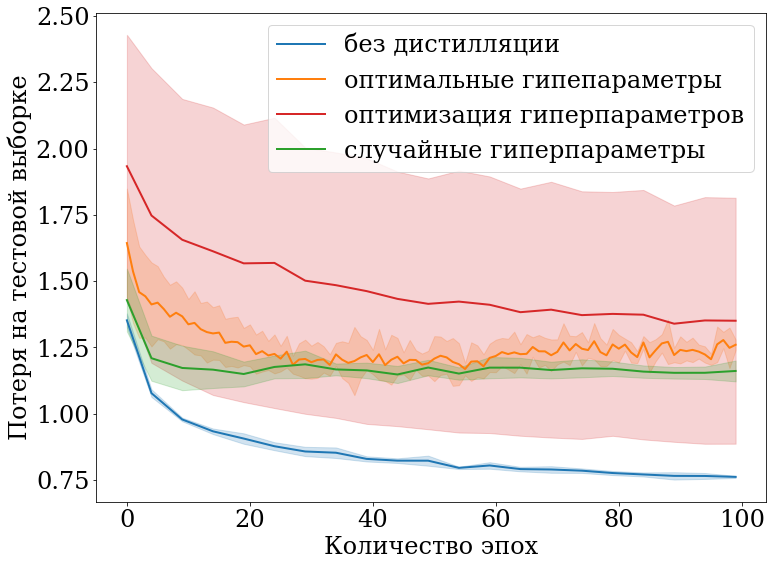

In [8]:
plot_data_params(data_b, 'test loss', 'без дистилляции', 'tab:blue', '')
plot_data_params(data_d, 'test loss', 'оптимальные гипепараметры', 'tab:orange', '')
plot_data_params(data_dr, 'test loss', 'оптимизация гиперпараметров', 'tab:red', '')
plot_data_params(data_h, 'test loss', 'случайные гиперпараметры', 'tab:green', '')

plt.xlabel('Количество эпох')
plt.ylabel('Потеря на тестовой выборке')

plt.legend()
plt.savefig('../figs/loss_22.pdf')

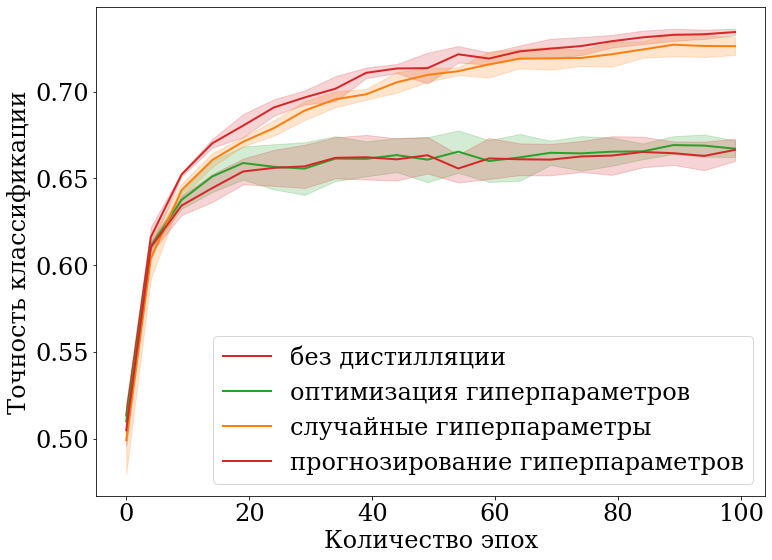

In [9]:
plot_data_params(data_b, 'accuracy', 'без дистилляции', 'tab:red', '')
#plot_data_params(data_d, 'accuracy', 'оптимальные гипепараметры', 'tab:blue', '')
plot_data_params(data_h, 'accuracy', 'оптимизация гиперпараметров', 'tab:green', '')
plot_data_params(data_dr, 'accuracy', 'случайные гиперпараметры', 'tab:orange', '')
plot_data_params(data_s, 'accuracy', 'прогнозирование гиперпараметров', 'tab:red', '')

plt.xlabel('Количество эпох')
plt.ylabel('Точность классификации')
plt.legend()
plt.savefig('../figs/acc_22.pdf')

In [24]:
np.mean([f['results'][-1]['accuracy'] for f in data_dr]), np.mean([f['results'][-1]['accuracy'] for f in data_h])


(0.6595999598503113, 0.667116661866506)

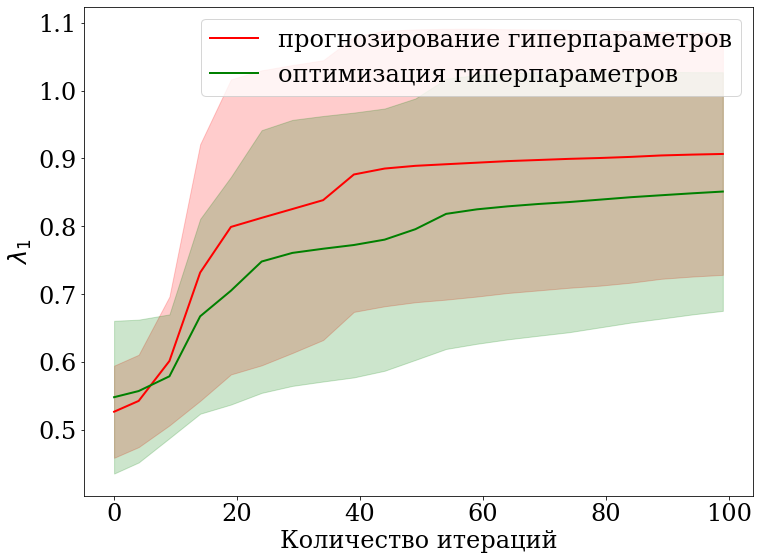

In [9]:
plot_data_params(data_s, 'lambda1', 'прогнозирование гиперпараметров', 'red', '')
# plot_data_params(data_dr, 'lambda1', 'случайные гиперпараметров', 'blue', '')
plot_data_params(data_h, 'lambda1', 'оптимизация гиперпараметров', 'green', '')
plt.xlabel('Количество итераций')
plt.ylabel(r'$\lambda_1$')
# plt.title(r'График зависимости значения $\lambda_1$ от номера итерации')
plt.legend()
plt.savefig('../figs/lambda1_iter22.pdf')
plt.show()

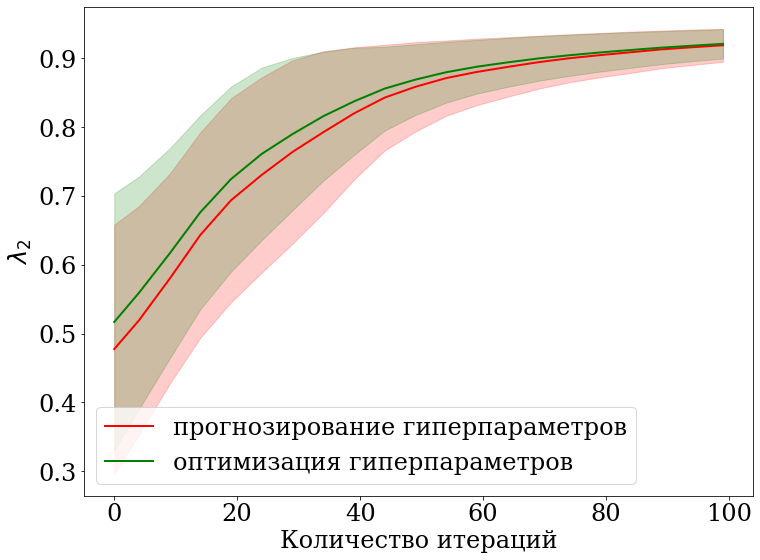

In [25]:
plot_data_params(data_s, 'lambda2', 'прогнозирование гиперпараметров', 'red', '')
# plot_data_params(data_dr, 'lambda2', 'случайные гиперпараметров', 'blue', '')
plot_data_params(data_h, 'lambda2', 'оптимизация гиперпараметров', 'green', '')
plt.xlabel('Количество итераций')
plt.ylabel(r'$\lambda_2$')
# plt.title(r'График зависимости значения $\lambda_2$ от номера итерации')
plt.legend()
plt.savefig('../figs/lambda2_iter22.pdf')
plt.show()

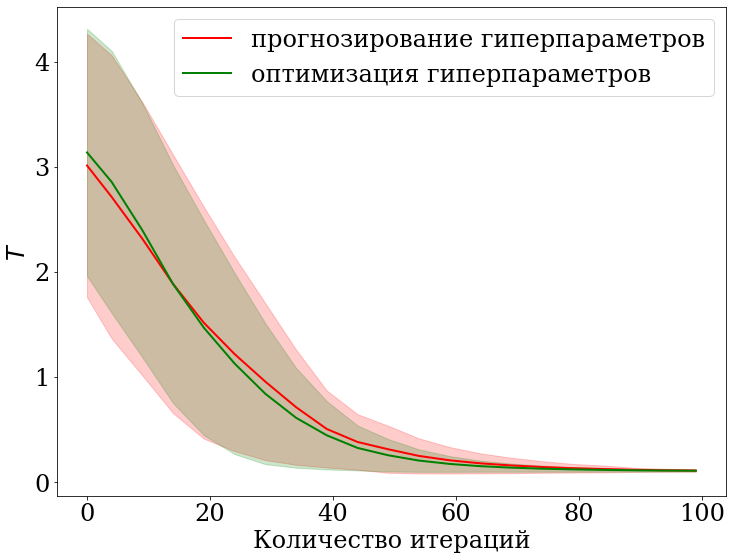

In [26]:
plot_data_params(data_s, 'temp', 'прогнозирование гиперпараметров', 'red', '')
#plot_data_params(data_dr, 'temp', 'случайные гиперпараметров', 'blue', '')
plot_data_params(data_h, 'temp', 'оптимизация гиперпараметров', 'green', '')
plt.xlabel('Количество итераций')
plt.ylabel(r'$T$')
# plt.title(r'График зависимости значения $T$ от номера итерации')
plt.legend()
plt.savefig('../figs/temp_iter22.pdf')
plt.show()

In [22]:
data_5 = open_data_json("../log/exp11_dist_h_b2_optim.jsonl")
data_2 = open_data_json("../log/exp12_dist_h_b2_optim.jsonl")
data_3 = open_data_json("../log/exp13_dist_h_b2_optim.jsonl")
data_10 = open_data_json("../log/exp14_dist_h_b2_optim.jsonl")

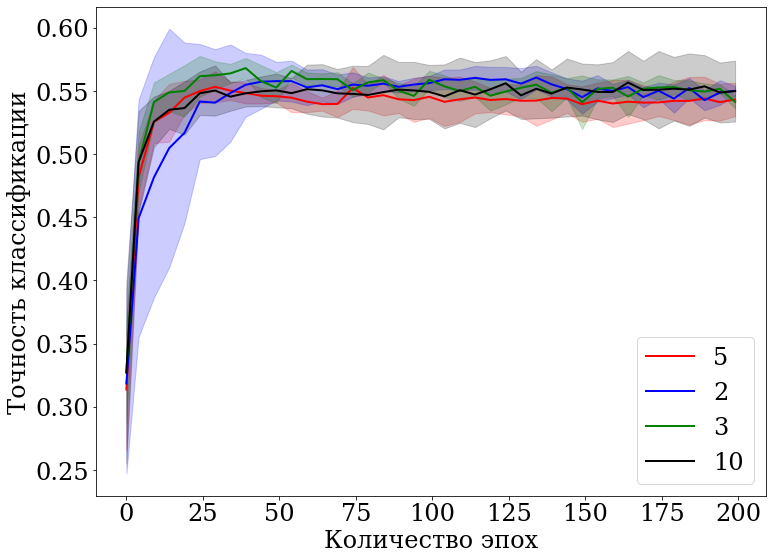

In [7]:
plot_data(data_5, '5', 'red')
plot_data(data_2, '2', 'blue')
plot_data(data_3, '3', 'green')
plot_data(data_10, '10', 'black')

plt.xlabel('Количество эпох')
plt.ylabel('Точность классификации')
plt.legend()
plt.savefig('../figs/acc_splines_.pdf')

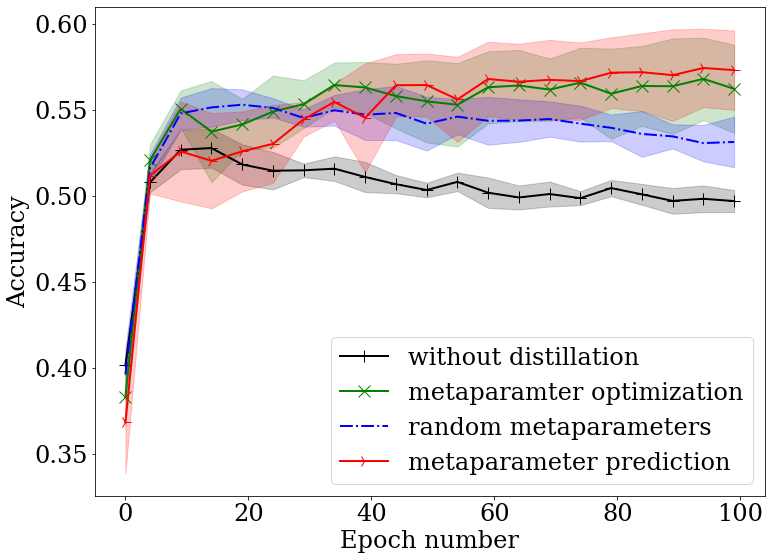

In [12]:
plot_data_params(data_b, 'accuracy', 'without distillation', 'black', '+')
plot_data_params(data_h, 'accuracy', 'metaparamter optimization', 'green', 'x')
plot_data_params(data_dr, 'accuracy', 'random metaparameters', 'blue', '.')
plot_data_params(data_s, 'accuracy', 'metaparameter prediction', 'red', '4')

plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('../figs/acc_'+experiment_version+'_eng.pdf')

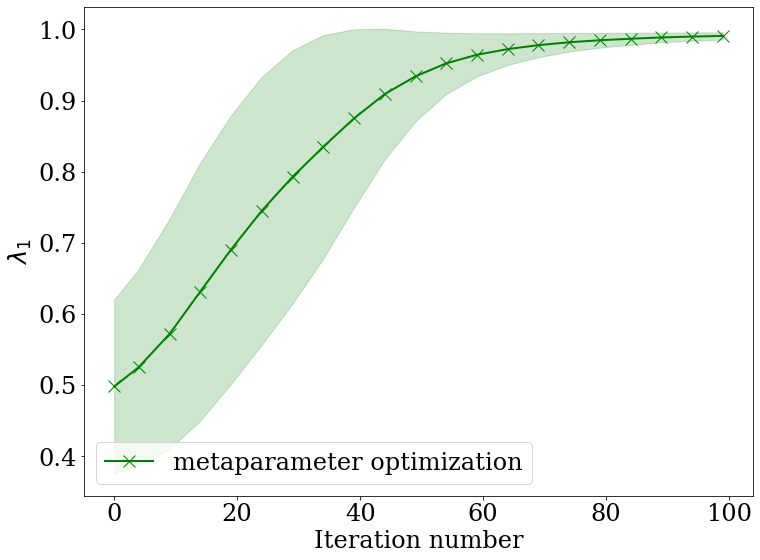

In [27]:
#plot_data_params(data_s, 'lambda1', 'metaparameter prediction', 'red', '+')
plot_data_params(data_h, 'lambda1', 'metaparameter optimization', 'green', 'x')
plt.xlabel('Iteration number')
plt.ylabel(r'$\lambda_1$')
plt.legend()
plt.savefig('../figs/lambda1_iter'+experiment_version+'_eng.pdf')
plt.show()

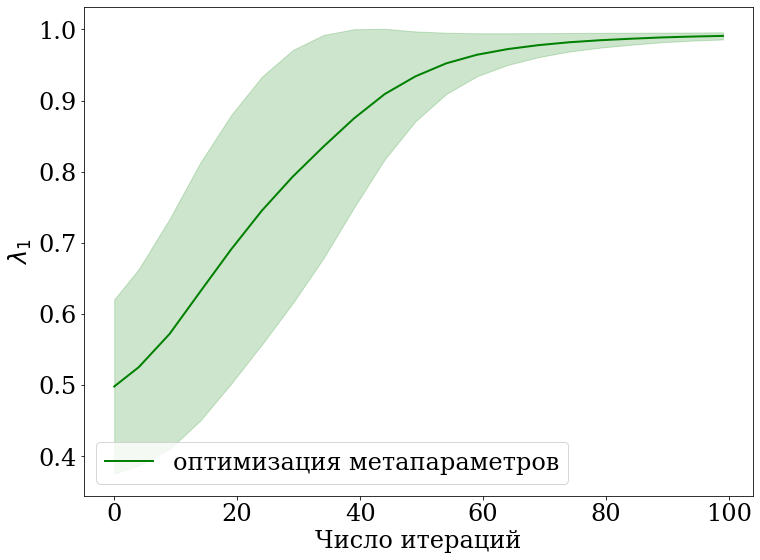

In [28]:
#plot_data_params(data_s, 'lambda1', 'прогнозирование метапараметров', 'red', '')
plot_data_params(data_h, 'lambda1', 'оптимизация метапараметров', 'green', '')
plt.xlabel('Число итераций')
plt.ylabel(r'$\lambda_1$')

plt.legend()
plt.savefig('../figs/lambda1_iter'+experiment_version+'_color.pdf')
plt.show()

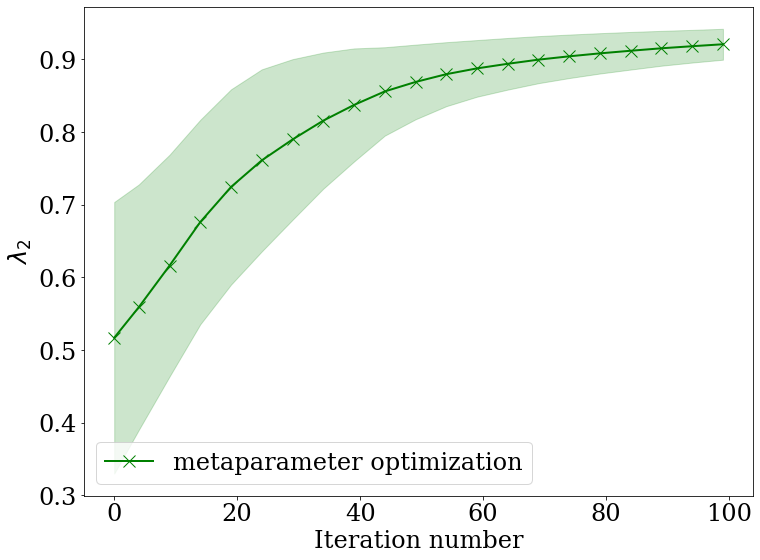

In [29]:
#plot_data_params(data_s, 'lambda2', 'metaparameter prediction', 'red', '+')
plot_data_params(data_h, 'lambda2', 'metaparameter optimization', 'green', 'x')
plt.xlabel('Iteration number')
plt.ylabel(r'$\lambda_2$')
plt.legend()
plt.savefig('../figs/lambda2_iter'+experiment_version+'_eng.pdf')
plt.show()

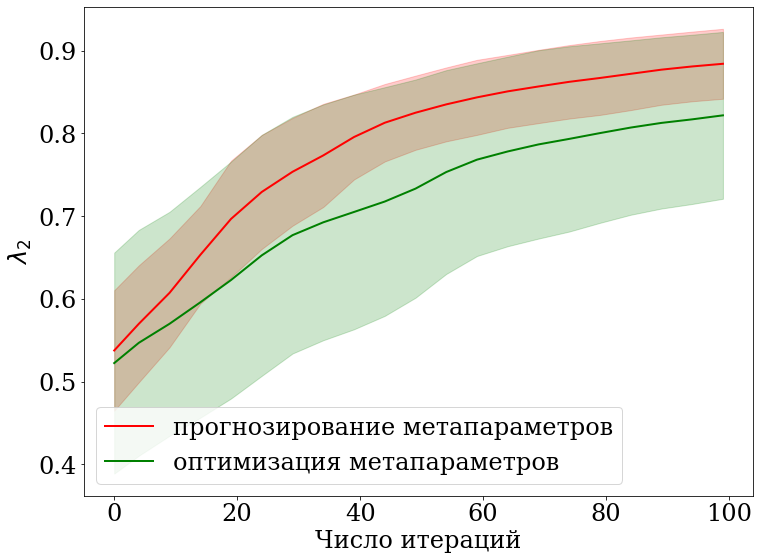

In [16]:
plot_data_params(data_s, 'lambda2', 'прогнозирование метапараметров', 'red', '')
plot_data_params(data_h, 'lambda2', 'оптимизация метапараметров', 'green', '')
plt.xlabel('Число итераций')
plt.ylabel(r'$\lambda_2$')
plt.legend()
plt.savefig('../figs/lambda2_iter'+experiment_version+'_color.pdf')
plt.show()

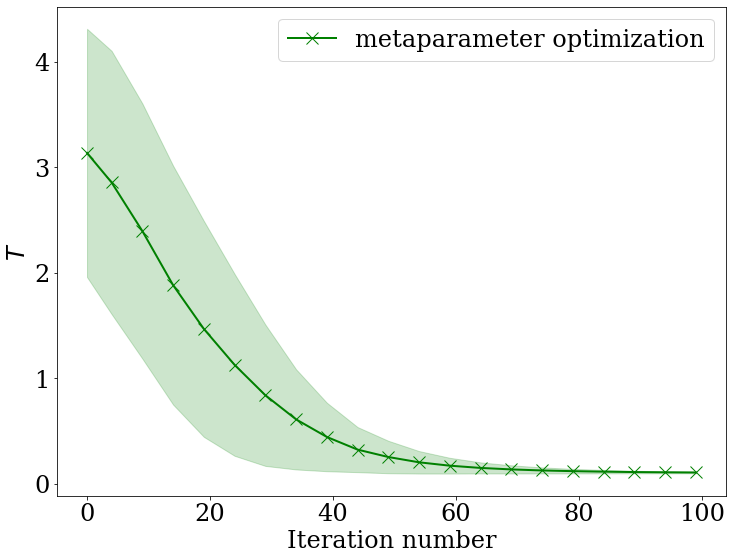

In [30]:
#plot_data_params(data_s, 'temp', 'metaparameter prediction', 'red', '+')
plot_data_params(data_h, 'temp', 'metaparameter optimization', 'green', 'x')
plt.xlabel('Iteration number')
plt.ylabel(r'$T$')
plt.legend()
plt.savefig('../figs/temp_iter'+experiment_version+'_eng.pdf')
plt.show()

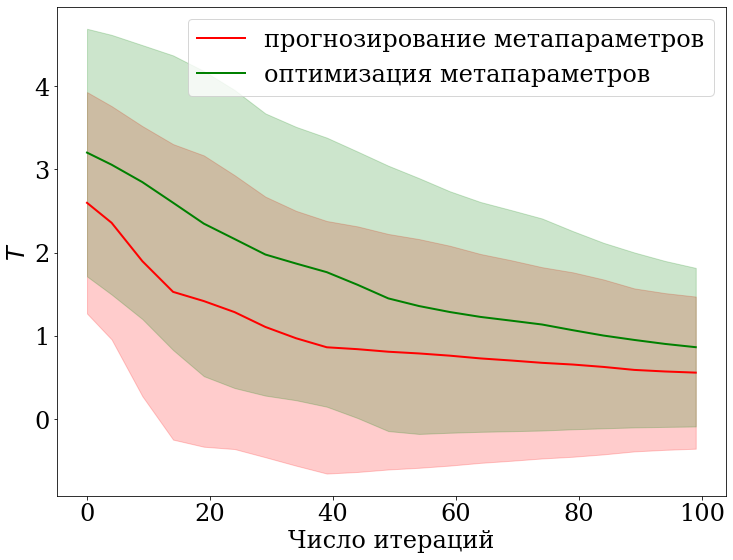

In [18]:
plot_data_params(data_s, 'temp', 'прогнозирование метапараметров', 'red', '')
plot_data_params(data_h, 'temp', 'оптимизация метапараметров', 'green', '')
plt.xlabel('Число итераций')
plt.ylabel(r'$T$')
plt.legend()
plt.savefig('../figs/temp_iter'+experiment_version+'_color.pdf')
plt.show()